In [1]:
import sys, os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
os.environ["PYTORCH_USE_CUDA_DSA"] = "1"
import numpy as np
import torch
import yaml
import pickle as pk
# autoreload modules
%load_ext autoreload
%autoreload 2

import matplotlib
%matplotlib inline
import matplotlib.pyplot as pl
import numpy as np
import sys,os
import readgadget
import MAS_library as MASL
import pickle as pk
import readfof
import matplotlib

import matplotlib.pyplot as pl
pl.rc('text', usetex=False)
# Palatino
pl.rc('font', family='DejaVu Sans')
%matplotlib inline



%load_ext Cython



        


In [2]:
import readfof
import sys, os
import numpy as np
import pickle as pk 
# from nbodykit.lab import *
import h5py as h5
import numpy as np
import Pk_library as PKL
import MAS_library as MASL
import yaml
# import galactic_wavelets as gw




In [4]:
# from test_ddp_PM_Mmin_13p0_nv64 import *
# from test_ddp_PM_Mmin_13p0_nv64_nemb_96 import *
from test_ddp_PM_Mmin_13p5_nv64 import *




In [5]:
dev = torch.device("cuda")
model = HaloDecoderModel(HaloConfig).to(dev)
# if rank == 0: print(f"Init model and loaded to GPU", flush=True)            
# model.to(device).bfloat16()
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

# scaler = torch.cuda.amp.GradScaler(enabled=(dtype == 'float16'))

# checkpoint = torch.load('/mnt/home/spandey/ceph/CHARFORMER/model_checkpoints/model_encdec_ddp_PM_isim_012_nvocab_96_nembed_64_CORRMASK_NOFLASH_FINAL.pt')
# checkpoint = torch.load('/mnt/home/spandey/ceph/CHARFORMER/model_checkpoints/model_encdec_ddp_PM_isim_012_nvocab_64_nembed_64_Mmin_13p0.pt')
# checkpoint = torch.load('/mnt/home/spandey/ceph/CHARFORMER/model_checkpoints/model_encdec_ddp_PM_isim_012_nvocab_64_nembed_96_Mmin_13p0.pt')
# checkpoint = torch.load('/mnt/home/spandey/ceph/CHARFORMER/model_checkpoints/model_encdec_ddp_PM_isim_012_nvocab_64_nembed_64_Mmin_13p5.pt')
checkpoint = torch.load('/mnt/home/spandey/ceph/CHARFORMER/model_checkpoints/model_encdec_ddp_PM_isim_012_nvocab_64_nembed_64_Mmin_13p5_1600.pt')
model.load_state_dict(checkpoint['model'])
model.eval()
print()
model = model.bfloat16()




Using flash:  False
Using flash:  False
Using flash:  False
Using flash:  False
number of parameters: 0.71M



In [ ]:
# isim_fid_array = np.arange(7, 11)
isim_fid_array = np.arange(0, 3)
# isim_fid = 6
for isim_fid in isim_fid_array:
    df = pk.load(open(f'/mnt/home/spandey/ceph/GOTHAM/data/PM/df_halo_part_ngp_xyzM_tokenized_PM_384x384x384_density3Dgrid_32_isim_{isim_fid}_snap_3_nvocab64_Mmin_1e13p5.pkl','rb'))

    dfhalo_ngp_xyzM_tokenized_padded_ended_squeezed_0 = df['dfhalo_ngp_xyzM_tokenized_padded_ended_squeezed']
    dfhalo_ngp_wxyzM_0 = df['dfhalo_ngp_wxyzM']
    Nhalos_truth_0 = df['Nhalos_truth']
    delta_box_all_squeezed_0 = df['delta_box_all_squeezed']


    grid = 32
    shift_x_all, shift_y_all, shift_z_all = np.zeros((grid, grid, grid)), np.zeros((grid, grid, grid)), np.zeros((grid, grid, grid))
    for jx in range(grid):
        for jy in range(grid):
            for jz in range(grid):
                shift_x_all[jx, jy, jz] = jx
                shift_y_all[jx, jy, jz] = jy
                shift_z_all[jx, jy, jz] = jz

    shift_x_all_squeezed, shift_y_all_squeezed, shift_z_all_squeezed = shift_x_all.flatten(), shift_y_all.flatten(), shift_z_all.flatten()
    shift_all_squeezed = np.vstack([shift_x_all_squeezed, shift_y_all_squeezed, shift_z_all_squeezed]).T


    n1 = 32**3
    test_data_halos = dfhalo_ngp_xyzM_tokenized_padded_ended_squeezed_0[:n1]

    test_data_dm = delta_box_all_squeezed_0[:n1]

    x = torch.tensor(test_data_halos[:, :-1])
    y = torch.tensor(test_data_halos[:, 1:])
    dm = torch.tensor(test_data_dm)
    mask_test_orig = x != 1
    mask_test = torch.logical_not(mask_test_orig)
    masked_logits = torch.zeros(mask_test.shape)
    mask_test_final = masked_logits.masked_fill(mask_test, float('-inf'))
    mask_test = mask_test_final[:,None,:]
    x, y = torch.tensor(x), torch.tensor(y)
    x_test = x.long()
    y_test = y.long()
    dm_test = dm.bfloat16()
    mask_test = torch.tensor(mask_test).bfloat16()

    x_test_gpu = x_test.to(dev)
    y_test_gpu = y_test.to(dev)
    dm_test_gpu = dm_test.to(dev)
    mask_test_gpu = mask_test.to(dev)


    def get_batch(split, ji=0, batch_size=None):
        if split == 'train':
            x = x_train_gpu
            y = y_train_gpu
            mask = mask_train_gpu
            dm = dm_train_gpu

        elif split == 'val':
            x = x_val_gpu
            y = y_val_gpu
            mask = mask_val_gpu
            dm = dm_val_gpu

        elif split == 'test':
            x = x_test_gpu
            y = y_test_gpu
            mask = mask_test_gpu
            dm = dm_test_gpu        

        if batch_size is not None:
            x = x[batch_size*(ji):batch_size*(ji+1)].to(dev, non_blocking=True)
            y = y[batch_size*(ji):batch_size*(ji+1)].to(dev, non_blocking=True)
            mask = mask[batch_size*(ji):batch_size*(ji+1)].to(dev, non_blocking=True)
            dm = dm[batch_size*(ji):batch_size*(ji+1)].to(dev, non_blocking=True)

        return x, y, mask, dm

    batch_size = 32**3
    X_val, Y_val, MASK_val, DM_val = get_batch('test', 0, batch_size)
    DM_val = torch.moveaxis(DM_val, -1, 1)
    # DM_val.shape

    DM_val_tosplit = DM_val.detach().cpu().to(torch.float16).numpy()[:batch_size, 0,:,:,:].reshape(batch_size, DM_val.shape[-1]**3)
    DM_val_tosplit_mean = np.mean(DM_val_tosplit, axis=-1)

    vlow = 0.00075
    vmid = 0.0017

    indlow = np.where(DM_val_tosplit_mean < vlow)[0]
    indmid = np.where((DM_val_tosplit_mean >= vlow) & (DM_val_tosplit_mean < vmid))[0]
    indhigh = np.where(DM_val_tosplit_mean >= vmid)[0]

    print(len(indlow), len(indmid), len(indhigh))

    max_new_tokens = df['max_sentence_length']
    nvocab = df['nvocab_total'] - 3

    bins_digitize = np.linspace(-1e-3, 1, nvocab)
    # bins_digitize.insert(0, -1)
    bins_digitize = np.insert(bins_digitize, 0, -1)


    start_token = 0
    pad_token = 1
    end_token = nvocab + 1
    space_token = nvocab + 2


    from tqdm import tqdm

    # end_token = 65
    # nvox_samp = 32**3
    # nbatches = 32
    fac = 32
    nvox_samp = fac*32**2
    nbatches = fac
    nvox_per_batch = nvox_samp // nbatches

    # idx_all = []
    # idx_all = torch.ones((nvox_samp, max_new_tokens), dtype=torch.long, device=dev)
    idx_all = np.ones((nvox_samp, max_new_tokens))
    for jb in tqdm(range(nbatches)):

        idx_inp = torch.zeros((nvox_per_batch, 1), dtype=torch.long, device=dev)

        DM_val_jb = DM_val[jb*nvox_per_batch:(jb+1)*nvox_per_batch,...]

        new_samples_jb = np.ones((nvox_per_batch, max_new_tokens))

        ind_jb = np.arange(nvox_per_batch)

        new_samples_jb[:, 0] = idx_inp[:,0].cpu().detach().numpy()
        # idx = idx_inp
        for jt in range(1, max_new_tokens):
            if len(ind_jb) > 0:
                # crop idx to the last block_size tokens
                idx_cond = torch.tensor(new_samples_jb[ind_jb, :jt], dtype=torch.long, device=dev)
                # get the predictions
                logits, loss = model(idx_cond, DM_val_jb[ind_jb,...])
                # focus only on the last time step
                logits = logits[:, -1, :] # becomes (B, C)
                # apply softmax to get probabilities
                probs = F.softmax(logits, dim=-1) # (B, C)
                # sample from the distribution
                idx_next = torch.multinomial(probs, num_samples=1).cpu().detach().numpy() # (B, 1)

                # append sampled index to the running sequence
                # if idx_next == end_token:
                    # break
                new_samples_jb[ind_jb, jt] = idx_next[:,0]
                ind_to_del = np.where(idx_next[:,0] == end_token)[0]
                # for jv in range(len(ind_jb)):
                    # if idx_next[jv, 0] == end_token:
                if len(ind_to_del) > 0:
                    ind_jb = np.delete(ind_jb, ind_to_del)


            # print(new_samples_jb[0,:])
            # idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        idx_all[jb*nvox_per_batch:(jb+1)*nvox_per_batch, :] = new_samples_jb
        # idx_all.append(idx)

    Mmin_cut = 10**13.5
    lgMin = np.log10(Mmin_cut)
    lgMax = 15.5

    BoxSize = 1000.
    grid = 32
    xmin = BoxSize/grid/2

    Nhalo_all_truth = []
    Mhalo_all_truth = []
    pos_all_truth = []
    Pk_all_truth = []

    MAS     = 'NGP'  #mass-assigment scheme
    grid_Pk = 16
    threads = 10

    for jv in range(nvox_samp):
    # for jv in indhigh[:nvox_samp]:    
        idx = X_val[jv]
        idx = idx.cpu().numpy().flatten().astype(int)
        # idx = idx[1:]
        # idx = idx[:np.where(idx == end_token)[0][0]]
        # idx = idx.reshape(-1, 5)
        idxe = np.where(idx == space_token)[0] + 1
        idx0 = np.where(idx == start_token)[0] + 1
        # check with idx0 is a scalar or an array:
        # try:
            # temp = len(idx0)
            # print(temp)
        # except:
        if len(idx0) == 1:
            if idx[idx0] != end_token:
                Nhalo = len(idxe) + len(idx0)
                Nhalo_all_truth.append(Nhalo)
                pos_halo = np.zeros((Nhalo, 3))
                pos_halo_unshifted = np.zeros((Nhalo, 3))        
                if Nhalo > 0:
                    try:
                        Mhalo = np.zeros(Nhalo)
                        for jh in range(Nhalo):
                            if jh == 0:
                                Mhalo[jh] = bins_digitize[idx[idx0]] * (lgMax - lgMin) + lgMin
                                for jx in range(3):
                                    # if jx == 0:
                                    shift_coord = shift_all_squeezed[jv, jx] * (2 * xmin)
                                    pos_halo[jh, jx] = bins_digitize[idx[idx0 + jx + 1]] * 2 * xmin  + shift_coord        
                                    pos_halo_unshifted[jh, jx] = pos_halo[jh, jx] - shift_coord

                            else:
                                if Nhalo > 2:
                                    Mhalo[jh] = bins_digitize[idx[idxe[jh-1]]] * (lgMax - lgMin) + lgMin
                                    for jx in range(3):
                                        shift_coord = shift_all_squeezed[jv, jx] * (2 * xmin)
                                        pos_halo[jh, jx] = bins_digitize[idx[idxe[jh-1] + jx + 1]] * 2 * xmin  + shift_coord
                                        pos_halo_unshifted[jh, jx] = pos_halo[jh, jx] - shift_coord

                                else:
                                    Mhalo[jh] = bins_digitize[idx[idxe]] * (lgMax - lgMin) + lgMin
                                    for jx in range(3):
                                        shift_coord = shift_all_squeezed[jv, jx] * (2 * xmin)
                                        pos_halo[jh, jx] = bins_digitize[idx[idxe + jx + 1]] * 2 * xmin  + shift_coord    
                                        pos_halo_unshifted[jh, jx] = pos_halo[jh, jx] - shift_coord

                        Mhalo_all_truth.append(Mhalo)
                        pos_all_truth.append(pos_halo)

                        if Nhalo > 5:
                            mesh_truth = np.zeros((grid_Pk, grid_Pk, grid_Pk), dtype=np.float32)
                            MASL.MA(pos_halo_unshifted.astype(np.float32), mesh_truth, 2*xmin, MAS)
                            mesh_truth /= np.mean(mesh_truth, dtype=np.float64);  mesh_truth -= 1.0
                            Pk_truth = PKL.Pk(mesh_truth, 2*xmin, axis=0, MAS=None, threads=threads, verbose=False)
                            Pk_all_truth.append(Pk_truth.Pk[:,0])
                        else:
                            Pk_all_truth.append([])

                    except:
                        Nhalo_all_truth.pop()
                        Nhalo_all_truth.append(0)
                        Mhalo_all_truth.append(np.array([]))
                        pos_all_truth.append(np.array([]))
                        Pk_all_truth.append([])
                        pass
            else:
                Nhalo_all_truth.append(0)            
                Mhalo_all_truth.append(np.array([]))
                pos_all_truth.append(np.array([]))
                Pk_all_truth.append([])
        else:
            Nhalo_all_truth.append(0)  
            Nhalo_all_truth.append(np.array([]))
            Mhalo_all_truth.append(np.array([]))
            pos_all_truth.append(np.array([]))
            Pk_all_truth.append([])

    Nhalo_all = []
    Mhalo_all = []
    pos_all = []
    Pk_all = []


    for jv in range(nvox_samp):
    # for jv in indhigh[:nvox_samp]:    
        idx = idx_all[jv].astype(int)
        idx = idx.flatten()
        # idx = idx[1:]
        # idx = idx[:np.where(idx == end_token)[0][0]]
        # idx = idx.reshape(-1, 5)
        idxe = np.where(idx == space_token)[0] + 1
        idx0 = np.where(idx == start_token)[0] + 1
        # check with idx0 is a scalar or an array:
        # try:
            # temp = len(idx0)
            # print(temp)
        # except:

        if len(idx0) == 1:
            if idx[idx0] != end_token:
                Nhalo = len(idxe) + len(idx0)
                Nhalo_all.append(Nhalo)
                pos_halo = np.zeros((Nhalo, 3))
                pos_halo_unshifted = np.zeros((Nhalo, 3))
                if Nhalo > 0:
                    try:
                        Mhalo = np.zeros(Nhalo)
                        for jh in range(Nhalo):
                            if jh == 0:
                                Mhalo[jh] = bins_digitize[idx[idx0]] * (lgMax - lgMin) + lgMin
                                for jx in range(3):
                                    shift_coord = shift_all_squeezed[jv, jx] * (2 * xmin)
                                    pos_halo[jh, jx] = bins_digitize[idx[idx0 + jx + 1]] * 2 * xmin + shift_coord    
                                    pos_halo_unshifted[jh, jx] = pos_halo[jh, jx] - shift_coord

                            else:
                                if Nhalo > 2:
                                    Mhalo[jh] = bins_digitize[idx[idxe[jh-1]]] * (lgMax - lgMin) + lgMin
                                    for jx in range(3):
                                        shift_coord = shift_all_squeezed[jv, jx] * (2 * xmin)
                                        pos_halo[jh, jx] = bins_digitize[idx[idxe[jh-1] + jx + 1]] * 2 * xmin  + shift_coord   
                                        pos_halo_unshifted[jh, jx] = pos_halo[jh, jx] - shift_coord

                                else:
                                    Mhalo[jh] = bins_digitize[idx[idxe]] * (lgMax - lgMin) + lgMin
                                    for jx in range(3):
                                        shift_coord = shift_all_squeezed[jv, jx] * (2 * xmin)
                                        pos_halo[jh, jx] = bins_digitize[idx[idxe + jx + 1]] * 2 * xmin  + shift_coord 
                                        pos_halo_unshifted[jh, jx] = pos_halo[jh, jx] - shift_coord


                        Mhalo_all.append(Mhalo)
                        pos_all.append(pos_halo)

                        if Nhalo > 5:
                            mesh_truth = np.zeros((grid_Pk, grid_Pk, grid_Pk), dtype=np.float32)
                            MASL.MA(pos_halo_unshifted.astype(np.float32), mesh_truth, 2*xmin, MAS)
                            mesh_truth /= np.mean(mesh_truth, dtype=np.float64);  mesh_truth -= 1.0
                            Pk_truth = PKL.Pk(mesh_truth, 2*xmin, axis=0, MAS=None, threads=threads, verbose=False)
                            Pk_all.append(Pk_truth.Pk[:,0])
                        else:
                            Pk_all.append([])


                    except Exception as e:
                        Nhalo_all.pop()
                        Nhalo_all.append(0)
                        Mhalo_all.append(np.array([]))
                        pos_all.append(np.array([]))
                        Pk_all.append([])
                        # print(jv, e)
                        pass

            else:
                # Nhalo_all.append(np.array([]))
                Nhalo_all.append(0)            
                Mhalo_all.append(np.array([]))
                pos_all.append(np.array([]))
                Pk_all.append([])

        else:
            # Nhalo_all.append(np.array([]))
            Nhalo_all.append(0)                    
            Mhalo_all.append(np.array([]))
            pos_all.append(np.array([]))
            Pk_all.append([])


    Nhalo_all_truth_concat = []
    for jv in range(len(Nhalo_all_truth)):
        if type(Nhalo_all_truth[jv]) == int:
            Nhalo_all_truth_concat.append(Nhalo_all_truth[jv])

    Nhalo_all_concat = []
    for jv in range(len(Nhalo_all)):
        if type(Nhalo_all[jv]) == int:
            Nhalo_all_concat.append(Nhalo_all[jv])  

        
    Mhalo_all_truth_concat = []
    for jv in range(len(Mhalo_all_truth)):
        Mhalo_all_truth_concat.extend(Mhalo_all_truth[jv])

    Mhalo_all_concat = []
    for jv in range(len(Mhalo_all)):
        Mhalo_all_concat.extend(Mhalo_all[jv])  

        
    pos_all_truth_concat = []
    for jv in range(len(pos_all_truth)):
        if len(pos_all_truth[jv]) > 0:
            if len(pos_all_truth_concat) == 0:
                pos_all_truth_concat = pos_all_truth[jv]
            else:
                pos_all_truth_concat = np.vstack((pos_all_truth_concat, pos_all_truth[jv]))
            # pos_all_truth_concat.extend(pos_all_truth[jv])

    pos_all_concat = []
    for jv in range(len(pos_all)):
        if len(pos_all[jv]) > 0:
            if len(pos_all_concat) == 0:
                pos_all_concat = pos_all[jv]
            else:
                pos_all_concat = np.vstack((pos_all_concat, pos_all[jv]))
            # pos_all_concat.extend(pos_all[jv])  


    saved = {'pos_all':pos_all_concat,
                'pos_all_truth':pos_all_truth_concat,
                'Mhalo_all':Mhalo_all_concat,
                'Mhalo_all_truth':Mhalo_all_truth_concat,
                'Nhalo_all':Nhalo_all_concat,
                'Nhalo_all_truth':Nhalo_all_truth_concat,
                # 'Pk_all':Pk_all_concat,
                # 'Pk_all_truth':Pk_all_truth_concat
                }

    pk.dump(saved, open(f'/mnt/home/spandey/ceph/GOTHAM/results/pos_M_Nhalo_all_truth_concat_PM_isim_{isim_fid}_nvocab_64_nembed_64_Mmin_1e13p5.pkl', 'wb'))

            


/tmp/ipykernel_708657/3855369813.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x, y = torch.tensor(x), torch.tensor(y)
/tmp/ipykernel_708657/3855369813.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask_test = torch.tensor(mask_test).bfloat16()


7183 24607 978


100%|██████████| 32/32 [01:08<00:00,  2.13s/it]
/tmp/ipykernel_708657/3855369813.py:205: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Mhalo[jh] = bins_digitize[idx[idx0]] * (lgMax - lgMin) + lgMin
/tmp/ipykernel_708657/3855369813.py:209: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pos_halo[jh, jx] = bins_digitize[idx[idx0 + jx + 1]] * 2 * xmin  + shift_coord
/tmp/ipykernel_708657/3855369813.py:221: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Mhalo[jh] = bins_d

7173 24596 999


100%|██████████| 32/32 [01:08<00:00,  2.13s/it]


7303 24412 1053


100%|██████████| 32/32 [01:09<00:00,  2.17s/it]


In [6]:
# isim_fid_array = np.arange(7, 11)
# isim_fid_array = np.arange(0, 3)
# isim_fid = 6
# for isim_fid in isim_fid_array:
isim_fid = 3
df = pk.load(open(f'/mnt/home/spandey/ceph/CHARFORMER/data/PM/df_halo_part_ngp_xyzM_tokenized_PM_384x384x384_density3Dgrid_32_isim_{isim_fid}_snap_3_nvocab64_Mmin_1e13p5.pkl','rb'))

dfhalo_ngp_xyzM_tokenized_padded_ended_squeezed_0 = df['dfhalo_ngp_xyzM_tokenized_padded_ended_squeezed']
dfhalo_ngp_wxyzM_0 = df['dfhalo_ngp_wxyzM']
Nhalos_truth_0 = df['Nhalos_truth']
delta_box_all_squeezed_0 = df['delta_box_all_squeezed']


grid = 32
shift_x_all, shift_y_all, shift_z_all = np.zeros((grid, grid, grid)), np.zeros((grid, grid, grid)), np.zeros((grid, grid, grid))
for jx in range(grid):
    for jy in range(grid):
        for jz in range(grid):
            shift_x_all[jx, jy, jz] = jx
            shift_y_all[jx, jy, jz] = jy
            shift_z_all[jx, jy, jz] = jz

shift_x_all_squeezed, shift_y_all_squeezed, shift_z_all_squeezed = shift_x_all.flatten(), shift_y_all.flatten(), shift_z_all.flatten()
shift_all_squeezed = np.vstack([shift_x_all_squeezed, shift_y_all_squeezed, shift_z_all_squeezed]).T


n1 = 32**3
test_data_halos = dfhalo_ngp_xyzM_tokenized_padded_ended_squeezed_0[:n1]

test_data_dm = delta_box_all_squeezed_0[:n1]

x = torch.tensor(test_data_halos[:, :-1])
y = torch.tensor(test_data_halos[:, 1:])
dm = torch.tensor(test_data_dm)
mask_test_orig = x != 1
mask_test = torch.logical_not(mask_test_orig)
masked_logits = torch.zeros(mask_test.shape)
mask_test_final = masked_logits.masked_fill(mask_test, float('-inf'))
mask_test = mask_test_final[:,None,:]
x, y = torch.tensor(x), torch.tensor(y)
x_test = x.long()
y_test = y.long()
dm_test = dm.bfloat16()
mask_test = torch.tensor(mask_test).bfloat16()

x_test_gpu = x_test.to(dev)
y_test_gpu = y_test.to(dev)
dm_test_gpu = dm_test.to(dev)
mask_test_gpu = mask_test.to(dev)


def get_batch(split, ji=0, batch_size=None):
    if split == 'train':
        x = x_train_gpu
        y = y_train_gpu
        mask = mask_train_gpu
        dm = dm_train_gpu

    elif split == 'val':
        x = x_val_gpu
        y = y_val_gpu
        mask = mask_val_gpu
        dm = dm_val_gpu

    elif split == 'test':
        x = x_test_gpu
        y = y_test_gpu
        mask = mask_test_gpu
        dm = dm_test_gpu        

    if batch_size is not None:
        x = x[batch_size*(ji):batch_size*(ji+1)].to(dev, non_blocking=True)
        y = y[batch_size*(ji):batch_size*(ji+1)].to(dev, non_blocking=True)
        mask = mask[batch_size*(ji):batch_size*(ji+1)].to(dev, non_blocking=True)
        dm = dm[batch_size*(ji):batch_size*(ji+1)].to(dev, non_blocking=True)

    return x, y, mask, dm

batch_size = 32**3
X_val, Y_val, MASK_val, DM_val = get_batch('test', 0, batch_size)
DM_val = torch.moveaxis(DM_val, -1, 1)
# DM_val.shape

DM_val_tosplit = DM_val.detach().cpu().to(torch.float16).numpy()[:batch_size, 0,:,:,:].reshape(batch_size, DM_val.shape[-1]**3)
DM_val_tosplit_mean = np.mean(DM_val_tosplit, axis=-1)

vlow = 0.00075
vmid = 0.0017

indlow = np.where(DM_val_tosplit_mean < vlow)[0]
indmid = np.where((DM_val_tosplit_mean >= vlow) & (DM_val_tosplit_mean < vmid))[0]
indhigh = np.where(DM_val_tosplit_mean >= vmid)[0]

print(len(indlow), len(indmid), len(indhigh))

max_new_tokens = df['max_sentence_length']
nvocab = df['nvocab_total'] - 3

bins_digitize = np.linspace(-1e-3, 1, nvocab)
# bins_digitize.insert(0, -1)
bins_digitize = np.insert(bins_digitize, 0, -1)


start_token = 0
pad_token = 1
end_token = nvocab + 1
space_token = nvocab + 2


from tqdm import tqdm

# end_token = 65
# nvox_samp = 32**3
# nbatches = 32
fac = 32
nvox_samp = fac*32**2
nbatches = fac
nvox_per_batch = nvox_samp // nbatches

# idx_all = []
# idx_all = torch.ones((nvox_samp, max_new_tokens), dtype=torch.long, device=dev)
idx_all = np.ones((nvox_samp, max_new_tokens))
for jb in tqdm(range(nbatches)):

    idx_inp = torch.zeros((nvox_per_batch, 1), dtype=torch.long, device=dev)

    DM_val_jb = DM_val[jb*nvox_per_batch:(jb+1)*nvox_per_batch,...]

    new_samples_jb = np.ones((nvox_per_batch, max_new_tokens))

    ind_jb = np.arange(nvox_per_batch)

    new_samples_jb[:, 0] = idx_inp[:,0].cpu().detach().numpy()
    # idx = idx_inp
    for jt in range(1, max_new_tokens):
        if len(ind_jb) > 0:
            # crop idx to the last block_size tokens
            idx_cond = torch.tensor(new_samples_jb[ind_jb, :jt], dtype=torch.long, device=dev)
            # get the predictions
            logits, loss = model(idx_cond, DM_val_jb[ind_jb,...])
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1).cpu().detach().numpy() # (B, 1)

            # append sampled index to the running sequence
            # if idx_next == end_token:
                # break
            new_samples_jb[ind_jb, jt] = idx_next[:,0]
            ind_to_del = np.where(idx_next[:,0] == end_token)[0]
            # for jv in range(len(ind_jb)):
                # if idx_next[jv, 0] == end_token:
            if len(ind_to_del) > 0:
                ind_jb = np.delete(ind_jb, ind_to_del)


        # print(new_samples_jb[0,:])
        # idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
    idx_all[jb*nvox_per_batch:(jb+1)*nvox_per_batch, :] = new_samples_jb
    # idx_all.append(idx)



/tmp/ipykernel_1104866/974906931.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x, y = torch.tensor(x), torch.tensor(y)
/tmp/ipykernel_1104866/974906931.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask_test = torch.tensor(mask_test).bfloat16()


7298 24475 995


100%|██████████| 32/32 [01:20<00:00,  2.52s/it]


In [14]:
# jv = 465
jv = indhigh[0]
id_start = 0
id_space = idx_all[jv][::5][1:]
M_jv = idx_all[jv, 1:][::5]
id_space, M_jv


(array([66., 66., 66., 66., 66., 66., 66., 66., 66., 66., 65.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.]),
 array([33., 31., 27., 15., 11., 11.,  9.,  9.,  8.,  5.,  3.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.]))

In [15]:
# idx_all[jv]
np.diff(M_jv)


array([ -2.,  -4., -12.,  -4.,   0.,  -2.,   0.,  -1.,  -3.,  -2.,  -2.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.])

In [22]:
from tqdm import tqdm
id_space_wrong = []
id_non_desc = []
num_space_wrong = []
for jv in tqdm(range(nvox_samp)):
    idx_jv = idx_all[jv,:]
    id_space_jv = idx_all[jv][::5][1:]
    M_jv = idx_all[jv, 1:][::5]

    if np.any(np.isin(id_space_jv, np.array([space_token, end_token, pad_token])) != True):
        id_space_wrong.append(jv)
        num_space_wrong.append(np.sum(np.isin(id_space_jv, np.array([space_token, end_token, pad_token])) != True))
    
    if np.any(np.diff(M_jv) > 0):
        id_non_desc.append(jv)



100%|██████████| 32768/32768 [00:00<00:00, 43925.88it/s]


In [2]:
# id_space_jv
# id_space_jv  [space_token, end_token, pad_token]
# np.isin(id_space_jv, np.array([space_token, end_token, pad_token]))
# id_space_wrong, id_non_desc
# id_non_desc[0]
# idx_all[id_non_desc[10]]
# len(id_non_desc)
# len(id_space_wrong)
# idx_all[id_space_wrong[20]]
import h5py as h5
f = h5.File('/mnt/home/spandey/ceph/CHARFORMER/data/PM/df_halo_part_ngp_xyzM_tokenized_PM_384x384x384_density3Dgrid_32_isim_012_snap_3_nvocab64_Mmin_13p5.h5', 'r')
dfhalo_ngp_xyzM_tokenized_padded_ended_squeezed_all = f['dfhalo_ngp_xyzM_tokenized_padded_ended_squeezed_all'][:]
delta_box_all_squeezed_all = f['delta_box_all_squeezed_all'][:]
nvocab_total = f['nvocab_total'][()]
grid_size = f['grid'][()]
start_token = f['start_token'][()]
pad_token = f['pad_token'][()]
end_token = f['end_token'][()]
max_sentence_length = f['max_sentence_length'][()]
f.close()


In [3]:
max_sentence_length



101

In [29]:
isim_fid_array = np.arange(0, 10)
M_all = []
snapnum = 3
mass_type = 'rockstar_200c'
snap_dir_base = '/mnt/home/fvillaescusa/ceph/Quijote/Halos/Rockstar/fiducial_HR'

for isim_fid in isim_fid_array:
    snapdir = snap_dir_base + '/' + str(isim_fid)  #folder hosting the catalogue
    rockstar = np.loadtxt(snapdir + '/out_' + str(snapnum) + '_pid.list')
    with open(snapdir + '/out_' + str(snapnum) + '_pid.list', 'r') as f:
        lines = f.readlines()
    header = lines[0].split()

    index_M = header.index('M200c')                    
    mass_truth = rockstar[:,index_M]  #Halo masses in Msun/h
    M_all.append(mass_truth)




In [30]:
logM_all = np.log10(np.concatenate(M_all))



/tmp/ipykernel_1104866/26522825.py:1: RuntimeWarning: divide by zero encountered in log10
  logM_all = np.log10(np.concatenate(M_all))


In [35]:
from colossus.cosmology import cosmology
params = {'flat': True, 'H0': 67.11, 'Om0': 0.3175, 'Ob0': 0.049, 'sigma8': 0.834, 'ns': 0.9624}
cosmo = cosmology.setCosmology('myCosmo', **params)
# get halo mass function:
from colossus.lss import mass_function
lgMmin = 12.5
lgMmax = 15.5
lgM_array = np.linspace(lgMmin, lgMmax, 1000)
M_array = 10**lgM_array
z_inference = 0.5
# if '200c' in mass_type:
dndlnM = mass_function.massFunction(M_array, float(z_inference), mdef = '200c', model = 'tinker08', q_out = 'dndlnM')

dlnM = np.log(M_array[1]/M_array[0])
dndM = dndlnM * M_array
dn = dndM * dlnM
n = np.cumsum(dn)



In [33]:
len(n), len(M_array)


(1000, 1000)

Text(0, 0.5, 'Histogram')

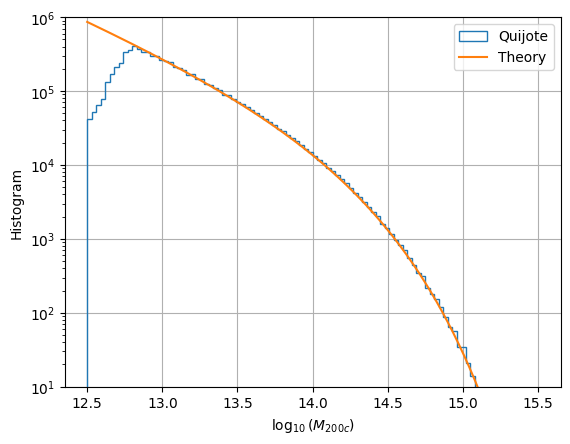

In [55]:
pl.figure()
_ = pl.hist(logM_all,bins=100, histtype='step', range=(12.5, 15.5), label='Quijote')
pl.plot(lgM_array, 0.6711*dndlnM * 1e9, label='Theory')
# pl.plot(lgM_array, n, label='Theory')
pl.yscale('log')
pl.ylim(10, 1e6)
pl.grid()
pl.legend()
pl.xlabel(r'$\log_{10}(M_{200c})$')
pl.ylabel(r'Histogram')


In [134]:
Mmin_cut = 10**13.5
lgMin = np.log10(Mmin_cut)
lgMax = 15.5

BoxSize = 1000.
grid = 32
xmin = BoxSize/grid/2

Nhalo_all_truth = []
Mhalo_all_truth = []
pos_all_truth = []
Pk_all_truth = []

MAS     = 'NGP'  #mass-assigment scheme
grid_Pk = 16
threads = 10

for jv in range(nvox_samp):
# for jv in indhigh[:nvox_samp]:    
    idx = X_val[jv]
    idx = idx.cpu().numpy().flatten().astype(int)
    # idx = idx[1:]
    # idx = idx[:np.where(idx == end_token)[0][0]]
    # idx = idx.reshape(-1, 5)
    idxe = np.where(idx == space_token)[0] + 1
    idx0 = np.where(idx == start_token)[0] + 1
    # check with idx0 is a scalar or an array:
    # try:
        # temp = len(idx0)
        # print(temp)
    # except:
    if len(idx0) == 1:
        if idx[idx0] != end_token:
            Nhalo = len(idxe) + len(idx0)
            Nhalo_all_truth.append(Nhalo)
            pos_halo = np.zeros((Nhalo, 3))
            pos_halo_unshifted = np.zeros((Nhalo, 3))        
            if Nhalo > 0:
                try:
                    Mhalo = np.zeros(Nhalo)
                    for jh in range(Nhalo):
                        if jh == 0:
                            Mhalo[jh] = bins_digitize[idx[idx0]] * (lgMax - lgMin) + lgMin
                            for jx in range(3):
                                # if jx == 0:
                                shift_coord = shift_all_squeezed[jv, jx] * (2 * xmin)
                                pos_halo[jh, jx] = bins_digitize[idx[idx0 + jx + 1]] * 2 * xmin  + shift_coord        
                                pos_halo_unshifted[jh, jx] = pos_halo[jh, jx] - shift_coord

                        else:
                            if Nhalo > 2:
                                Mhalo[jh] = bins_digitize[idx[idxe[jh-1]]] * (lgMax - lgMin) + lgMin
                                for jx in range(3):
                                    shift_coord = shift_all_squeezed[jv, jx] * (2 * xmin)
                                    pos_halo[jh, jx] = bins_digitize[idx[idxe[jh-1] + jx + 1]] * 2 * xmin  + shift_coord
                                    pos_halo_unshifted[jh, jx] = pos_halo[jh, jx] - shift_coord

                            else:
                                Mhalo[jh] = bins_digitize[idx[idxe]] * (lgMax - lgMin) + lgMin
                                for jx in range(3):
                                    shift_coord = shift_all_squeezed[jv, jx] * (2 * xmin)
                                    pos_halo[jh, jx] = bins_digitize[idx[idxe + jx + 1]] * 2 * xmin  + shift_coord    
                                    pos_halo_unshifted[jh, jx] = pos_halo[jh, jx] - shift_coord

                    Mhalo_all_truth.append(Mhalo)
                    pos_all_truth.append(pos_halo)

                    if Nhalo > 5:
                        mesh_truth = np.zeros((grid_Pk, grid_Pk, grid_Pk), dtype=np.float32)
                        MASL.MA(pos_halo_unshifted.astype(np.float32), mesh_truth, 2*xmin, MAS)
                        mesh_truth /= np.mean(mesh_truth, dtype=np.float64);  mesh_truth -= 1.0
                        Pk_truth = PKL.Pk(mesh_truth, 2*xmin, axis=0, MAS=None, threads=threads, verbose=False)
                        Pk_all_truth.append(Pk_truth.Pk[:,0])
                    else:
                        Pk_all_truth.append([])

                except:
                    Nhalo_all_truth.pop()
                    Nhalo_all_truth.append(0)
                    Mhalo_all_truth.append(np.array([]))
                    pos_all_truth.append(np.array([]))
                    Pk_all_truth.append([])
                    pass
        else:
            Nhalo_all_truth.append(0)            
            Mhalo_all_truth.append(np.array([]))
            pos_all_truth.append(np.array([]))
            Pk_all_truth.append([])
    else:
        Nhalo_all_truth.append(0)  
        Nhalo_all_truth.append(np.array([]))
        Mhalo_all_truth.append(np.array([]))
        pos_all_truth.append(np.array([]))
        Pk_all_truth.append([])

Nhalo_all = []
Mhalo_all = []
pos_all = []
Pk_all = []


for jv in range(nvox_samp):
# for jv in indhigh[:nvox_samp]:    
    idx = idx_all[jv].astype(int)
    idx = idx.flatten()
    # idx = idx[1:]
    # idx = idx[:np.where(idx == end_token)[0][0]]
    # idx = idx.reshape(-1, 5)
    idxe = np.where(idx == space_token)[0] + 1
    idx0 = np.where(idx == start_token)[0] + 1
    # check with idx0 is a scalar or an array:
    # try:
        # temp = len(idx0)
        # print(temp)
    # except:

    if len(idx0) == 1:
        if idx[idx0] != end_token:
            Nhalo = len(idxe) + len(idx0)
            Nhalo_all.append(Nhalo)
            pos_halo = np.zeros((Nhalo, 3))
            pos_halo_unshifted = np.zeros((Nhalo, 3))
            if Nhalo > 0:
                try:
                    Mhalo = np.zeros(Nhalo)
                    for jh in range(Nhalo):
                        if jh == 0:
                            Mhalo[jh] = bins_digitize[idx[idx0]] * (lgMax - lgMin) + lgMin
                            for jx in range(3):
                                shift_coord = shift_all_squeezed[jv, jx] * (2 * xmin)
                                pos_halo[jh, jx] = bins_digitize[idx[idx0 + jx + 1]] * 2 * xmin + shift_coord    
                                pos_halo_unshifted[jh, jx] = pos_halo[jh, jx] - shift_coord

                        else:
                            if Nhalo > 2:
                                Mhalo[jh] = bins_digitize[idx[idxe[jh-1]]] * (lgMax - lgMin) + lgMin
                                for jx in range(3):
                                    shift_coord = shift_all_squeezed[jv, jx] * (2 * xmin)
                                    pos_halo[jh, jx] = bins_digitize[idx[idxe[jh-1] + jx + 1]] * 2 * xmin  + shift_coord   
                                    pos_halo_unshifted[jh, jx] = pos_halo[jh, jx] - shift_coord

                            else:
                                Mhalo[jh] = bins_digitize[idx[idxe]] * (lgMax - lgMin) + lgMin
                                for jx in range(3):
                                    shift_coord = shift_all_squeezed[jv, jx] * (2 * xmin)
                                    pos_halo[jh, jx] = bins_digitize[idx[idxe + jx + 1]] * 2 * xmin  + shift_coord 
                                    pos_halo_unshifted[jh, jx] = pos_halo[jh, jx] - shift_coord


                    Mhalo_all.append(Mhalo)
                    pos_all.append(pos_halo)

                    if Nhalo > 5:
                        mesh_truth = np.zeros((grid_Pk, grid_Pk, grid_Pk), dtype=np.float32)
                        MASL.MA(pos_halo_unshifted.astype(np.float32), mesh_truth, 2*xmin, MAS)
                        mesh_truth /= np.mean(mesh_truth, dtype=np.float64);  mesh_truth -= 1.0
                        Pk_truth = PKL.Pk(mesh_truth, 2*xmin, axis=0, MAS=None, threads=threads, verbose=False)
                        Pk_all.append(Pk_truth.Pk[:,0])
                    else:
                        Pk_all.append([])


                except Exception as e:
                    Nhalo_all.pop()
                    Nhalo_all.append(0)
                    Mhalo_all.append(np.array([]))
                    pos_all.append(np.array([]))
                    Pk_all.append([])
                    # print(jv, e)
                    pass

        else:
            # Nhalo_all.append(np.array([]))
            Nhalo_all.append(0)            
            Mhalo_all.append(np.array([]))
            pos_all.append(np.array([]))
            Pk_all.append([])

    else:
        # Nhalo_all.append(np.array([]))
        Nhalo_all.append(0)                    
        Mhalo_all.append(np.array([]))
        pos_all.append(np.array([]))
        Pk_all.append([])


Nhalo_all_truth_concat = []
for jv in range(len(Nhalo_all_truth)):
    if type(Nhalo_all_truth[jv]) == int:
        Nhalo_all_truth_concat.append(Nhalo_all_truth[jv])

Nhalo_all_concat = []
for jv in range(len(Nhalo_all)):
    if type(Nhalo_all[jv]) == int:
        Nhalo_all_concat.append(Nhalo_all[jv])  

    
Mhalo_all_truth_concat = []
for jv in range(len(Mhalo_all_truth)):
    Mhalo_all_truth_concat.extend(Mhalo_all_truth[jv])

Mhalo_all_concat = []
for jv in range(len(Mhalo_all)):
    Mhalo_all_concat.extend(Mhalo_all[jv])  

    
pos_all_truth_concat = []
for jv in range(len(pos_all_truth)):
    if len(pos_all_truth[jv]) > 0:
        if len(pos_all_truth_concat) == 0:
            pos_all_truth_concat = pos_all_truth[jv]
        else:
            pos_all_truth_concat = np.vstack((pos_all_truth_concat, pos_all_truth[jv]))
        # pos_all_truth_concat.extend(pos_all_truth[jv])

pos_all_concat = []
for jv in range(len(pos_all)):
    if len(pos_all[jv]) > 0:
        if len(pos_all_concat) == 0:
            pos_all_concat = pos_all[jv]
        else:
            pos_all_concat = np.vstack((pos_all_concat, pos_all[jv]))
        # pos_all_concat.extend(pos_all[jv])  


saved = {'pos_all':pos_all_concat,
            'pos_all_truth':pos_all_truth_concat,
            'Mhalo_all':Mhalo_all_concat,
            'Mhalo_all_truth':Mhalo_all_truth_concat,
            'Nhalo_all':Nhalo_all_concat,
            'Nhalo_all_truth':Nhalo_all_truth_concat,
            # 'Pk_all':Pk_all_concat,
            # 'Pk_all_truth':Pk_all_truth_concat
            }

# pk.dump(saved, open(f'/mnt/home/spandey/ceph/CHARFORMER/results/pos_M_Nhalo_all_truth_concat_PM_isim_{isim_fid}_nvocab_64_nembed_64_Mmin_1e13p5.pkl', 'wb'))

        


/tmp/ipykernel_708657/2682590823.py:35: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Mhalo[jh] = bins_digitize[idx[idx0]] * (lgMax - lgMin) + lgMin
/tmp/ipykernel_708657/2682590823.py:39: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pos_halo[jh, jx] = bins_digitize[idx[idx0 + jx + 1]] * 2 * xmin  + shift_coord
/tmp/ipykernel_708657/2682590823.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Mhalo[jh] = bins_digitize[idx[idxe]] * (lgMax - lgMin) + lgMin
/tmp/i

/tmp/ipykernel_708657/2682590823.py:120: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Mhalo[jh] = bins_digitize[idx[idx0]] * (lgMax - lgMin) + lgMin
/tmp/ipykernel_708657/2682590823.py:123: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pos_halo[jh, jx] = bins_digitize[idx[idx0 + jx + 1]] * 2 * xmin + shift_coord
/tmp/ipykernel_708657/2682590823.py:135: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Mhalo[jh] = bins_digitize[idx[idxe]] * (lgMax - lgMin) + lgMin
/tmp

In [ ]:
Nhalo_all_truth = []
Mhalo_all_truth = []
pos_all_truth = []
Pk_all_truth = []

MAS     = 'NGP'  #mass-assigment scheme
grid_Pk = 16
threads = 10

for jv in range(nvox_samp):
# for jv in indhigh[:nvox_samp]:    
    idx = X_val[jv]
    idx = idx.cpu().numpy().flatten().astype(int)
    # idx = idx[1:]
    # idx = idx[:np.where(idx == end_token)[0][0]]
    # idx = idx.reshape(-1, 5)
    idxe = np.where(idx == space_token)[0] + 1
    idx0 = np.where(idx == start_token)[0] + 1
    # check with idx0 is a scalar or an array:
    # try:
        # temp = len(idx0)
        # print(temp)
    # except:
    if len(idx0) == 1:
        if idx[idx0] != end_token:
            Nhalo = len(idxe) + len(idx0)
            Nhalo_all_truth.append(Nhalo)
            pos_halo = np.zeros((Nhalo, 3))
            pos_halo_unshifted = np.zeros((Nhalo, 3))        
            if Nhalo > 0:
                try:
                    Mhalo = np.zeros(Nhalo)
                    for jh in range(Nhalo):
                        if jh == 0:
                            Mhalo[jh] = bins_digitize[idx[idx0]] * (lgMax - lgMin) + lgMin
                            for jx in range(3):
                                # if jx == 0:
                                shift_coord = shift_all_squeezed[jv, jx] * (2 * xmin)
                                pos_halo[jh, jx] = bins_digitize[idx[idx0 + jx + 1]] * 2 * xmin  + shift_coord        
                                pos_halo_unshifted[jh, jx] = pos_halo[jh, jx] - shift_coord

                        else:
                            if Nhalo > 2:
                                Mhalo[jh] = bins_digitize[idx[idxe[jh-1]]] * (lgMax - lgMin) + lgMin
                                for jx in range(3):
                                    shift_coord = shift_all_squeezed[jv, jx] * (2 * xmin)
                                    pos_halo[jh, jx] = bins_digitize[idx[idxe[jh-1] + jx + 1]] * 2 * xmin  + shift_coord
                                    pos_halo_unshifted[jh, jx] = pos_halo[jh, jx] - shift_coord

                            else:
                                Mhalo[jh] = bins_digitize[idx[idxe]] * (lgMax - lgMin) + lgMin
                                for jx in range(3):
                                    shift_coord = shift_all_squeezed[jv, jx] * (2 * xmin)
                                    pos_halo[jh, jx] = bins_digitize[idx[idxe + jx + 1]] * 2 * xmin  + shift_coord    
                                    pos_halo_unshifted[jh, jx] = pos_halo[jh, jx] - shift_coord

                    Mhalo_all_truth.append(Mhalo)
                    pos_all_truth.append(pos_halo)

                    if Nhalo > 5:
                        mesh_truth = np.zeros((grid_Pk, grid_Pk, grid_Pk), dtype=np.float32)
                        MASL.MA(pos_halo_unshifted.astype(np.float32), mesh_truth, 2*xmin, MAS)
                        mesh_truth /= np.mean(mesh_truth, dtype=np.float64);  mesh_truth -= 1.0
                        Pk_truth = PKL.Pk(mesh_truth, 2*xmin, axis=0, MAS=None, threads=threads, verbose=False)
                        Pk_all_truth.append(Pk_truth.Pk[:,0])
                    else:
                        Pk_all_truth.append([])

                except:
                    Nhalo_all_truth.pop()
                    Nhalo_all_truth.append(0)
                    Mhalo_all_truth.append(np.array([]))
                    pos_all_truth.append(np.array([]))
                    Pk_all_truth.append([])
                    pass
        else:
            Nhalo_all_truth.append(0)            
            Mhalo_all_truth.append(np.array([]))
            pos_all_truth.append(np.array([]))
            Pk_all_truth.append([])
    else:
        Nhalo_all_truth.append(0)  
        Nhalo_all_truth.append(np.array([]))
        Mhalo_all_truth.append(np.array([]))
        pos_all_truth.append(np.array([]))
        Pk_all_truth.append([])


/tmp/ipykernel_708657/841951432.py:35: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Mhalo[jh] = bins_digitize[idx[idx0]] * (lgMax - lgMin) + lgMin
/tmp/ipykernel_708657/841951432.py:39: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pos_halo[jh, jx] = bins_digitize[idx[idx0 + jx + 1]] * 2 * xmin  + shift_coord
/tmp/ipykernel_708657/841951432.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Mhalo[jh] = bins_digitize[idx[idxe]] * (lgMax - lgMin) + lgMin
/tmp/ipyk

In [ ]:
# idx0, idxe
# jtest= 1288
jtest = np.where(np.array(Nhalo_all_truth) == 0)[0][0]
len(pos_all_truth[jtest]), Nhalo_all_truth[jtest], len(Mhalo_all_truth[jtest])



(0, 0, 0)

In [ ]:
Nhalo_all = []
Mhalo_all = []
pos_all = []
Pk_all = []


for jv in range(nvox_samp):
# for jv in indhigh[:nvox_samp]:    
    idx = idx_all[jv].astype(int)
    idx = idx.flatten()
    # idx = idx[1:]
    # idx = idx[:np.where(idx == end_token)[0][0]]
    # idx = idx.reshape(-1, 5)
    idxe = np.where(idx == space_token)[0] + 1
    idx0 = np.where(idx == start_token)[0] + 1
    # check with idx0 is a scalar or an array:
    # try:
        # temp = len(idx0)
        # print(temp)
    # except:

    if len(idx0) == 1:
        if idx[idx0] != end_token:
            Nhalo = len(idxe) + len(idx0)
            Nhalo_all.append(Nhalo)
            pos_halo = np.zeros((Nhalo, 3))
            pos_halo_unshifted = np.zeros((Nhalo, 3))
            if Nhalo > 0:
                try:
                    Mhalo = np.zeros(Nhalo)
                    for jh in range(Nhalo):
                        if jh == 0:
                            Mhalo[jh] = bins_digitize[idx[idx0]] * (lgMax - lgMin) + lgMin
                            for jx in range(3):
                                shift_coord = shift_all_squeezed[jv, jx] * (2 * xmin)
                                pos_halo[jh, jx] = bins_digitize[idx[idx0 + jx + 1]] * 2 * xmin + shift_coord    
                                pos_halo_unshifted[jh, jx] = pos_halo[jh, jx] - shift_coord

                        else:
                            if Nhalo > 2:
                                Mhalo[jh] = bins_digitize[idx[idxe[jh-1]]] * (lgMax - lgMin) + lgMin
                                for jx in range(3):
                                    shift_coord = shift_all_squeezed[jv, jx] * (2 * xmin)
                                    pos_halo[jh, jx] = bins_digitize[idx[idxe[jh-1] + jx + 1]] * 2 * xmin  + shift_coord   
                                    pos_halo_unshifted[jh, jx] = pos_halo[jh, jx] - shift_coord

                            else:
                                Mhalo[jh] = bins_digitize[idx[idxe]] * (lgMax - lgMin) + lgMin
                                for jx in range(3):
                                    shift_coord = shift_all_squeezed[jv, jx] * (2 * xmin)
                                    pos_halo[jh, jx] = bins_digitize[idx[idxe + jx + 1]] * 2 * xmin  + shift_coord 
                                    pos_halo_unshifted[jh, jx] = pos_halo[jh, jx] - shift_coord


                    Mhalo_all.append(Mhalo)
                    pos_all.append(pos_halo)

                    if Nhalo > 5:
                        mesh_truth = np.zeros((grid_Pk, grid_Pk, grid_Pk), dtype=np.float32)
                        MASL.MA(pos_halo_unshifted.astype(np.float32), mesh_truth, 2*xmin, MAS)
                        mesh_truth /= np.mean(mesh_truth, dtype=np.float64);  mesh_truth -= 1.0
                        Pk_truth = PKL.Pk(mesh_truth, 2*xmin, axis=0, MAS=None, threads=threads, verbose=False)
                        Pk_all.append(Pk_truth.Pk[:,0])
                    else:
                        Pk_all.append([])


                except Exception as e:
                    Nhalo_all.pop()
                    Nhalo_all.append(0)
                    Mhalo_all.append(np.array([]))
                    pos_all.append(np.array([]))
                    Pk_all.append([])
                    # print(jv, e)
                    pass

        else:
            # Nhalo_all.append(np.array([]))
            Nhalo_all.append(0)            
            Mhalo_all.append(np.array([]))
            pos_all.append(np.array([]))
            Pk_all.append([])

    else:
        # Nhalo_all.append(np.array([]))
        Nhalo_all.append(0)                    
        Mhalo_all.append(np.array([]))
        pos_all.append(np.array([]))
        Pk_all.append([])



/tmp/ipykernel_708657/657509725.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Mhalo[jh] = bins_digitize[idx[idx0]] * (lgMax - lgMin) + lgMin
/tmp/ipykernel_708657/657509725.py:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pos_halo[jh, jx] = bins_digitize[idx[idx0 + jx + 1]] * 2 * xmin + shift_coord
/tmp/ipykernel_708657/657509725.py:48: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Mhalo[jh] = bins_digitize[idx[idxe]] * (lgMax - lgMin) + lgMin
/tmp/ipyke

In [ ]:
# np.array(Nhalo_all_truth).shape, 32**3
# np.array(Nhalo_all).shape, 32**3
# idx0, idxe
jtest= 1243
# jtest = np.where(np.array(Nhalo_all_truth) == 0)[0][0]
print(len(pos_all[jtest]), Nhalo_all[jtest], len(Mhalo_all[jtest]))
# print(len(pos_all_truth[jtest]), Nhalo_all_truth[jtest], len(Mhalo_all_truth[jtest]))




2 2 2


In [ ]:
# np.amin(np.array(Nhalo_all))


Text(0, 0.5, '$P_{\\rm mock}(k)/P_{\\rm truth}(k)$')

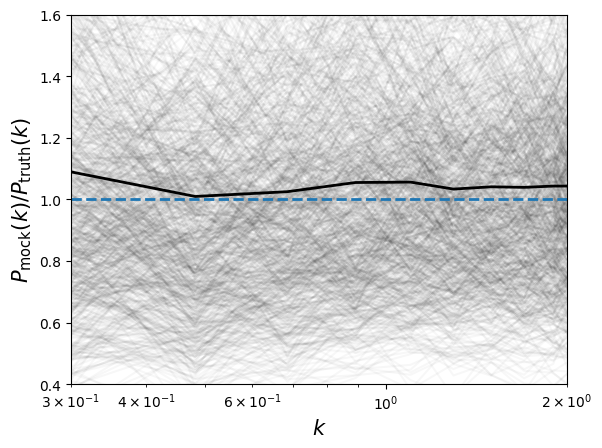

In [ ]:
pl.figure()
resid_all = []
# for jp in range(len(Pk_all)):
# for jp in indhigh:    
Pk_all_concat = []
Pk_all_truth_concat = []
# for jp in indlow:        
for jp in indhigh:       
# for jp in indmid:           
# for jp in range(nvox_samp):
# for jp in indmid[::10]:            
    if (len(Pk_all[jp]) > 0) and (len(Pk_all_truth[jp]) > 0):
        # pl.plot(Pk_truth.k3D, (Pk_all[jp] - Pk_all_truth[jp])/Pk_all_truth[jp], color='k', ls='-', alpha=0.0003)
        pl.plot(Pk_truth.k3D, (Pk_all[jp])/(Pk_all_truth[jp]), color='k', ls='-', alpha=0.03)
        resid_all.append((Pk_all[jp])/Pk_all_truth[jp])
        Pk_all_concat.append(Pk_all[jp])
        Pk_all_truth_concat.append(Pk_all_truth[jp])

Pk_all_concat = np.vstack(Pk_all_concat)
Pk_all_truth_concat = np.vstack(Pk_all_truth_concat)

resid_all = np.vstack(resid_all)
pl.plot(Pk_truth.k3D, np.mean(resid_all, axis=0), color='k', ls='-', alpha=1.0, lw=2.0)
pl.axhline(1.0, ls='--', lw=2.0)
pl.xscale('log')
pl.ylim(0.4, 1.6)
pl.xlim(0.3, 2)
# pl.scale('log')
pl.xlabel(r'$k$', size=15)
pl.ylabel(r'$P_{\rm mock}(k)/P_{\rm truth}(k)$', size=15)




Text(0, 0.5, '$P_{\\rm mock}(k)/P_{\\rm truth}(k)$')

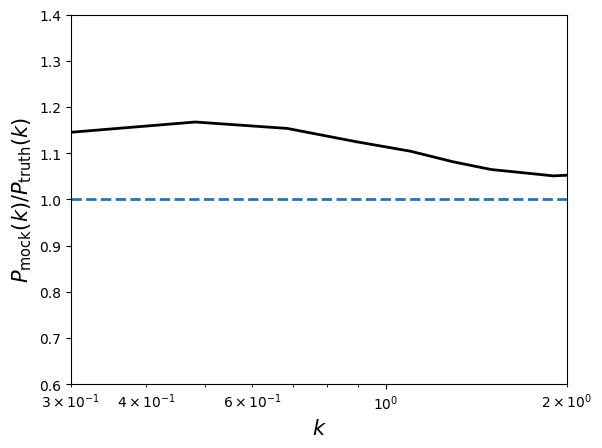

In [171]:
pl.figure()
resid_all = []
# for jp in range(len(Pk_all)):
# for jp in indhigh:    
Pk_all_concat = []
Pk_all_truth_concat = []
# for jp in indlow:        
# for jp in indhigh:       
for jp in range(nvox_samp):
# for jp in indmid[::10]:            
    if (len(Pk_all[jp]) > 0) and (len(Pk_all_truth[jp]) > 0):
        # pl.plot(Pk_truth.k3D, (Pk_all[jp] - Pk_all_truth[jp])/Pk_all_truth[jp], color='k', ls='-', alpha=0.0003)
        pl.plot(Pk_truth.k3D, (Pk_all[jp])/(Pk_all_truth[jp]), color='k', ls='-', alpha=0.0003)
        resid_all.append((Pk_all[jp])/Pk_all_truth[jp])
        Pk_all_concat.append(Pk_all[jp])
        Pk_all_truth_concat.append(Pk_all_truth[jp])

Pk_all_concat = np.vstack(Pk_all_concat)
Pk_all_truth_concat = np.vstack(Pk_all_truth_concat)

resid_all = np.vstack(resid_all)
pl.plot(Pk_truth.k3D, np.mean(resid_all, axis=0), color='k', ls='-', alpha=1.0, lw=2.0)
pl.axhline(1.0, ls='--', lw=2.0)
pl.xscale('log')
pl.ylim(0.6, 1.4)
pl.xlim(0.3, 2)
# pl.scale('log')
pl.xlabel(r'$k$', size=15)
pl.ylabel(r'$P_{\rm mock}(k)/P_{\rm truth}(k)$', size=15)




Text(0.5, 1.0, 'Power spectra of 32Mpc/$h$ sub-boxes')

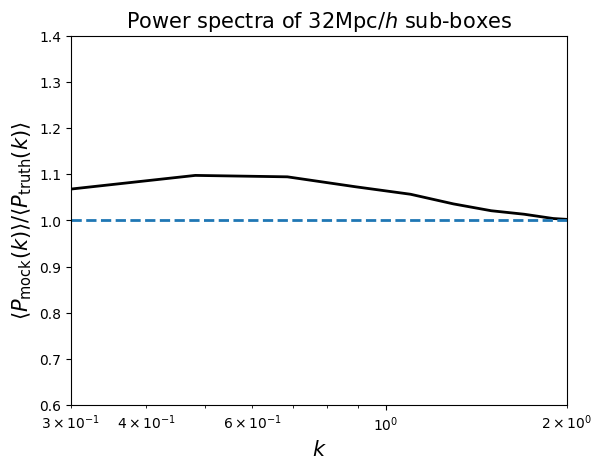

In [172]:
pl.figure()
pl.plot(Pk_truth.k3D, np.mean(Pk_all_concat, axis=0)/np.mean(Pk_all_truth_concat, axis=0), color='k', ls='-', alpha=1.0, lw=2.0)
pl.axhline(1.0, ls='--', lw=2.0)
pl.xscale('log')
pl.ylim(0.6, 1.4)
pl.xlim(0.3, 2)
# pl.scale('log')
pl.xlabel(r'$k$', size=15)
pl.ylabel(r'$\langle P_{\rm mock}(k) \rangle/\langle P_{\rm truth}(k) \rangle$', size=15)
pl.title(r'Power spectra of 32Mpc/$h$ sub-boxes', size=15)




Text(0.5, 1.0, 'Power spectra of 32Mpc/$h$ sub-boxes')

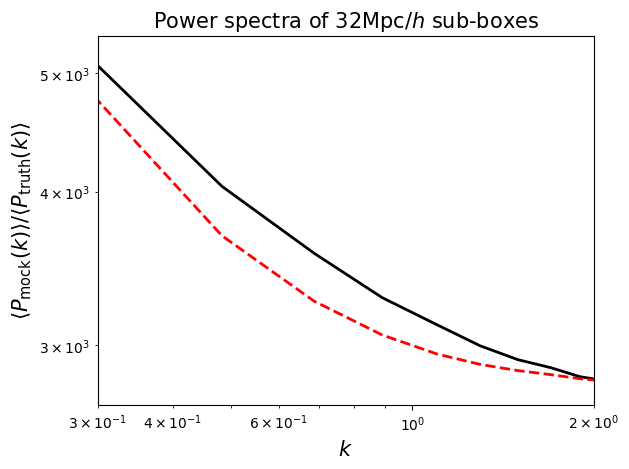

In [173]:
pl.figure()
pl.plot(Pk_truth.k3D, np.mean(Pk_all_concat, axis=0), color='k', ls='-', alpha=1.0, lw=2.0)
pl.plot(Pk_truth.k3D, np.mean(Pk_all_truth_concat, axis=0), color='r', ls='--', alpha=1.0, lw=2.0)
# pl.axhline(1.0, ls='--', lw=2.0)
pl.xscale('log')
pl.yscale('log')
# pl.ylim(0.6, 1.4)
pl.xlim(0.3, 2)
# pl.scale('log')
pl.xlabel(r'$k$', size=15)
pl.ylabel(r'$\langle P_{\rm mock}(k) \rangle/\langle P_{\rm truth}(k) \rangle$', size=15)
pl.title(r'Power spectra of 32Mpc/$h$ sub-boxes', size=15)




In [174]:
# Pk_all_concat.shape
# Pk_truth.k3D


Text(0.5, 1.0, 'Power spectra of 32Mpc/$h$ sub-boxes')

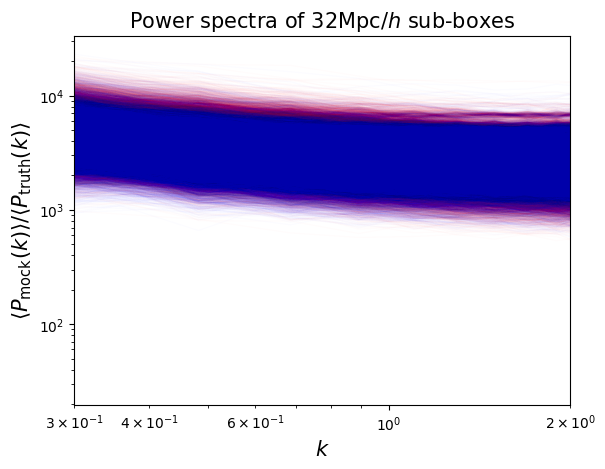

In [175]:
pl.figure()
for jp in range(len(Pk_all_concat)):
    pl.plot(Pk_truth.k3D, (Pk_all_concat[jp]), color='r', ls='-', alpha=0.01, lw=1.0)
for jp in range(len(Pk_all_concat)):    
    pl.plot(Pk_truth.k3D, (Pk_all_truth_concat[jp]), color='b', ls='-', alpha=0.01, lw=1.0)
# pl.axhline(1.0, ls='--', lw=2.0)
pl.xscale('log')
pl.yscale('log')
# pl.ylim(0.6, 1.4)
pl.xlim(0.3, 2)
# pl.scale('log')
pl.xlabel(r'$k$', size=15)
pl.ylabel(r'$\langle P_{\rm mock}(k) \rangle/\langle P_{\rm truth}(k) \rangle$', size=15)
pl.title(r'Power spectra of 32Mpc/$h$ sub-boxes', size=15)




In [176]:
# pl.figure()
# resid_all = []
# # for jp in range(len(Pk_all)):
# # for jp in indhigh:    
# for jp in indlow:        
#     if (len(Pk_all[jp]) > 0) and (len(Pk_all_truth[jp]) > 0):
#         # pl.plot(Pk_truth.k3D, (Pk_all[jp] - Pk_all_truth[jp])/Pk_all_truth[jp], color='k', ls='-', alpha=0.0003)
#         pl.plot(Pk_truth.k3D, (Pk_all[jp])/(Pk_all_truth[jp]), color='k', ls='-', alpha=0.03)
#         resid_all.append((Pk_all[jp])/Pk_all_truth[jp])

# resid_all = np.vstack(resid_all)
# pl.plot(Pk_truth.k3D, np.mean(resid_all, axis=0), color='k', ls='-', alpha=1.0, lw=2.0)
# pl.axhline(1.0, ls='--', lw=2.0)
# pl.xscale('log')
# pl.ylim(0.6, 1.4)
# pl.xlim(0.3, 2)
# # pl.scale('log')
# pl.xlabel(r'$k$', size=15)
# pl.ylabel(r'$P_{\rm mock}(k)/P_{\rm truth}(k)$', size=15)




In [ ]:
# np.amin(np.array(Nhalo_all_truth_concat))
np.amin(np.array(Nhalo_all_truth_concat)), np.amin(np.array(Nhalo_all_concat))


(0, 0)

In [ ]:
np.histogram(np.array(Nhalo_all_truth_concat), bins=53, range=(-1, 52))

(array([   0, 8770, 7379, 5345, 3843, 2568, 1767, 1080,  770,  458,  285,
         188,  119,   84,   57,   23,    7,    9,    2,    3,    2,    9,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0]),
 array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.,
        12., 13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24.,
        25., 26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37.,
        38., 39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50.,
        51., 52.]))

(0.0, 20.0)

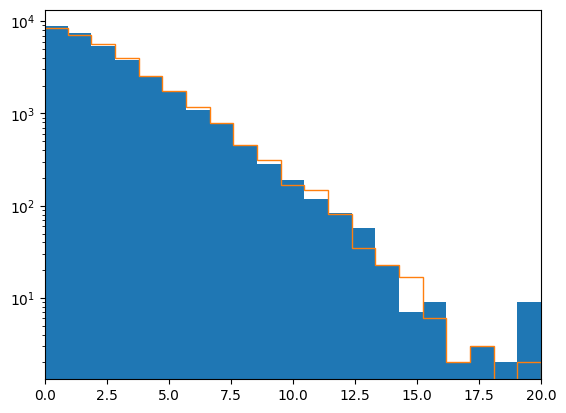

In [ ]:
# np.array(Nhalo_all_truth_concat).shape
pl.figure()
_ = pl.hist(np.array(Nhalo_all_truth_concat), range=(-1,20), bins=22)
_ = pl.hist(np.array(Nhalo_all_concat), range=(-1,20), bins=22, histtype='step')
pl.yscale('log')
pl.xlim(0,20)



In [ ]:
# len(Mhalo_all)
# len(np.array(Mhalo_all_truth_concat)), len(np.array(Mhalo_all_concat))
np.amin(np.array(Mhalo_all_truth_concat)), np.amax(np.array(Mhalo_all_concat))
                                           


(13.529777777777777, 15.404666666666666)

(13.5, 15.5)

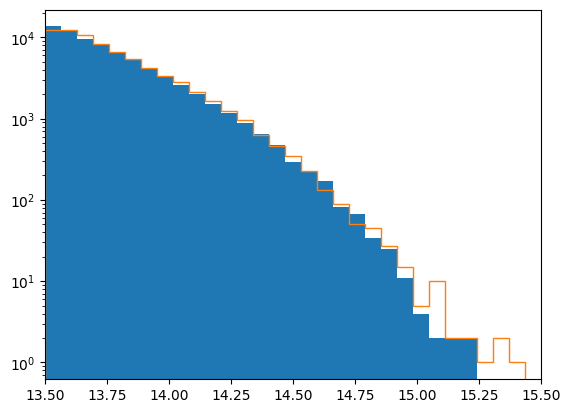

In [ ]:
# np.array(Nhalo_all_truth_concat).shape
pl.figure()
_ = pl.hist(np.array(Mhalo_all_truth_concat), range=(13.5,15.5), bins=31)
# _ = pl.hist(np.array(lgMass_truth_orig), range=(13,15.5), bins=21, histtype='step')
_ = pl.hist(np.array(Mhalo_all_concat), range=(13.5,15.5), bins=31, histtype='step')
pl.yscale('log')
pl.xlim(13.5, 15.5)
# lgMass_truth_orig


In [ ]:
# np.nonzero(Nhalo_all_truth_concat)[0].shape, np.nonzero(Nhalo_all_concat)[0].shape, pos_all_concat.shape, pos_all_truth_concat.shape

# np.nonzero(Nhalo_all_truth_concat)[0].shape, np.nonzero(Nhalo_all_concat)[0].shape


In [46]:
# import copy
# pos_all_concat_try1 = copy.deepcopy(pos_all_concat)
np.unique(np.array(Mhalo_all_truth_concat))


array([13.52977778, 13.56155556, 13.59333333, 13.62511111, 13.65688889,
       13.68866667, 13.72044444, 13.75222222, 13.784     , 13.81577778,
       13.84755556, 13.87933333, 13.91111111, 13.94288889, 13.97466667,
       14.00644444, 14.03822222, 14.07      , 14.10177778, 14.13355556,
       14.16533333, 14.19711111, 14.22888889, 14.26066667, 14.29244444,
       14.32422222, 14.356     , 14.38777778, 14.41955556, 14.45133333,
       14.48311111, 14.51488889, 14.54666667, 14.57844444, 14.61022222,
       14.642     , 14.67377778, 14.70555556, 14.73733333, 14.76911111,
       14.80088889, 14.83266667, 14.86444444, 14.89622222, 14.928     ,
       14.95977778, 14.99155556, 15.02333333, 15.05511111, 15.08688889])

In [110]:
# import copy
# pos_all_concat_try2 = copy.deepcopy(pos_all_concat)



In [111]:
# pos_all_concat_try1.shape

In [112]:
# pos_all_concat_try2


In [113]:
# # grid_Pk = 512
# grid_Pk_full = 512
# threads = 10
# MAS = 'CIC'
# mesh_mock = np.zeros((grid_Pk_full, grid_Pk_full, grid_Pk_full), dtype=np.float32)
# # indsel_M = np.where((np.array(Mhalo_all_concat) > Mmin_Pk) & (np.array(Mhalo_all_concat) < Mmax_Pk))[0]
# # print(f'Number of halos in tokenized mock cat {len(indsel_M)}')
# MASL.MA(pos_all_concat_try1.astype(np.float32), mesh_mock, 1000., MAS)
# mesh_mock1 = mesh_mock/np.mean(mesh_mock, dtype=np.float64);  mesh_mock1 -= 1.0
# Pk_mock1_full = PKL.Pk(mesh_mock1, 1000., axis=0, MAS=MAS, threads=threads, verbose=False)

# # grid_Pk = 512
# threads = 10
# MAS = 'CIC'
# mesh_mock = np.zeros((grid_Pk_full, grid_Pk_full, grid_Pk_full), dtype=np.float32)
# # indsel_M = np.where((np.array(Mhalo_all_concat) > Mmin_Pk) & (np.array(Mhalo_all_concat) < Mmax_Pk))[0]
# # print(f'Number of halos in tokenized mock cat {len(indsel_M)}')
# MASL.MA(pos_all_concat_try2.astype(np.float32), mesh_mock, 1000., MAS)
# mesh_mock2 = mesh_mock/np.mean(mesh_mock, dtype=np.float64);  mesh_mock2 -= 1.0
# Pk_mock2_full = PKL.Pk(mesh_mock2, 1000., axis=0, MAS=MAS, threads=threads, verbose=False)




# # Pk_truth_mock_full = PKL.XPk([mesh_mock, mesh_truth], 1000., axis=0, MAS=[MAS, MAS], threads=threads)




In [114]:
# pl.figure()
# pl.plot(Pk_mock1_full.k3D, Pk_mock1_full.Pk[:,0], color='r', ls='-', alpha=1.0, lw=1.0)
# pl.plot(Pk_mock2_full.k3D, Pk_mock2_full.Pk[:,0], color='b', ls='-', alpha=1.0, lw=1.0)
# pl.plot(Pk_truth_full_orig.k3D, Pk_truth_full_orig.Pk[:,0], color='k', ls='-', alpha=1.0, lw=1.0)
# pl.xscale('log')
# pl.yscale('log')


In [97]:
# np.amin(pos_all_truth_concat[:,2]), np.amax(pos_all_truth_concat[:,2])
np.amin(pos_all_concat[:,2]), np.amax(pos_all_concat[:,2])
# pos_all_truth_concat.shape



(0.4652777777777777, 1000.0)

In [98]:
# pl.figure(figsize=(6,6))
# pl.scatter(pos_all_concat[:,0], pos_all_concat[:,1], s=0.001)
# pl.title('Halos Mock (tokenized)', size=16)


In [99]:
# isim_fid = 1
snapnum = 3
mass_type = 'rockstar_200c'
snap_dir_base = '/mnt/home/fvillaescusa/ceph/Quijote/Halos/Rockstar/fiducial_HR'
snapdir = snap_dir_base + '/' + str(isim_fid)  #folder hosting the catalogue
rockstar = np.loadtxt(snapdir + '/out_' + str(snapnum) + '_pid.list')
with open(snapdir + '/out_' + str(snapnum) + '_pid.list', 'r') as f:
    lines = f.readlines()
header = lines[0].split()
# get the properties of the halos
pos_h_truth = rockstar[:,header.index('X'):header.index('Z')+1]
if mass_type == 'rockstar_vir':
    index_M = header.index('Mvir')                    
    mass_truth = rockstar[:,index_M]  #Halo masses in Msun/h
if mass_type == 'rockstar_200c':
    index_M = header.index('M200c')                    
    mass_truth = rockstar[:,index_M]  #Halo masses in Msun/h

Mmin_cut = 10**13.5
lgMass_truth = np.log10(mass_truth)
indsel = np.where(mass_truth > Mmin_cut)[0]
# print(grid, len(indsel), len(mass_truth), np.amin(lgMass_truth), np.log10(Mmin_cut))
pos_h_truth_orig = pos_h_truth[indsel]
lgMass_truth_orig = lgMass_truth[indsel]



/tmp/ipykernel_708657/4139340561.py:20: RuntimeWarning: divide by zero encountered in log10
  lgMass_truth = np.log10(mass_truth)


Text(0.5, 1.0, 'Halos Mock (tokenized)')

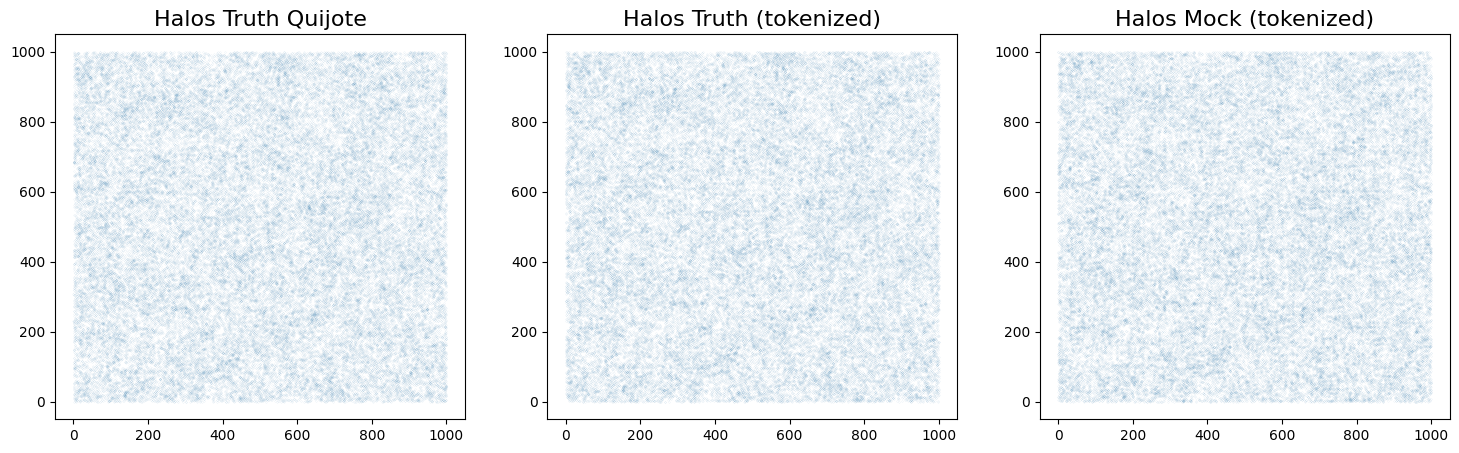

In [100]:
fig, (ax1, ax2, ax3) = pl.subplots(1, 3, figsize=(18, 5))
# fig.suptitle('Horizontally stacked subplots')
# ax1.plot(x, y)
# ax2.plot(x, -y)

ax1.scatter(pos_h_truth_orig[:,0], pos_h_truth_orig[:,1], s=0.001)
ax1.set_title('Halos Truth Quijote', size=16)


ax2.scatter(pos_all_truth_concat[:,0], pos_all_truth_concat[:,1], s=0.001)
ax2.set_title('Halos Truth (tokenized)', size=16)


# ax1.set_xlim(400,600)
# ax1.set_ylim(400,600)
# fig.add_subplot(121)
ax3.scatter(pos_all_concat[:,0], pos_all_concat[:,1], s=0.001)
ax3.set_title('Halos Mock (tokenized)', size=16)
# ax2.set_xlim(400,600)
# ax2.set_ylim(400,600)




In [101]:
# Mmin_Pk, Mmax_Pk = 13.5, np.inf
# Mmin_Pk, Mmax_Pk = 13.478, np.inf
Mmin_Pk, Mmax_Pk = 13.5, np.inf
# Mmin_Pk, Mmax_Pk = 13.5, 14.0
# Mmin_Pk, Mmax_Pk = -np.inf, np.inf
M1 = 14.0
# alpha = 0.66
alpha = 0.6




In [102]:
grid_Pk_full = 512
threads = 10
MAS = 'CIC'
mesh_truth = np.zeros((grid_Pk_full, grid_Pk_full, grid_Pk_full), dtype=np.float32)
indsel_M = np.where((lgMass_truth_orig > Mmin_Pk) & (lgMass_truth_orig < Mmax_Pk))[0]
print(f'Number of halos in original true cat {len(indsel_M)}')
W = (10**lgMass_truth_orig[indsel_M]/10**M1)**(alpha)
MASL.MA(pos_h_truth_orig[indsel_M].astype(np.float32), mesh_truth, 1000., MAS, W=W.astype(np.float32))
mesh_truth /= np.mean(mesh_truth, dtype=np.float64);  mesh_truth -= 1.0
Pk_truth_full_orig = PKL.Pk(mesh_truth, 1000., axis=0, MAS=MAS, threads=threads, verbose=False)



Number of halos in original true cat 72627


In [103]:
# grid_Pk_full = 512
threads = 10
MAS = 'CIC'
mesh_truth = np.zeros((grid_Pk_full, grid_Pk_full, grid_Pk_full), dtype=np.float32)
indsel_M = np.where((np.array(Mhalo_all_truth_concat) > Mmin_Pk) & (np.array(Mhalo_all_truth_concat) < Mmax_Pk))[0]
print(f'Number of halos in tokenized true cat {len(indsel_M)}')
W = (10**np.array(Mhalo_all_truth_concat)[indsel_M]/10**M1)**(alpha)
MASL.MA(pos_all_truth_concat[indsel_M].astype(np.float32), mesh_truth, 1000., MAS, W=W.astype(np.float32))
mesh_truth /= np.mean(mesh_truth, dtype=np.float64);  mesh_truth -= 1.0
Pk_truth_full = PKL.Pk(mesh_truth, 1000., axis=0, MAS=MAS, threads=threads, verbose=False)




Number of halos in tokenized true cat 72619


In [104]:
# grid_Pk = 512
threads = 10
MAS = 'CIC'
mesh_mock = np.zeros((grid_Pk_full, grid_Pk_full, grid_Pk_full), dtype=np.float32)
indsel_M = np.where((np.array(Mhalo_all_concat) > Mmin_Pk) & (np.array(Mhalo_all_concat) < Mmax_Pk))[0]
print(f'Number of halos in tokenized mock cat {len(indsel_M)}')
W = (10**np.array(Mhalo_all_concat)[indsel_M]/10**M1)**(alpha)
MASL.MA(pos_all_concat[indsel_M].astype(np.float32), mesh_mock, 1000., MAS, W=W.astype(np.float32))
mesh_mock /= np.mean(mesh_mock, dtype=np.float64);  mesh_mock -= 1.0
Pk_mock_full = PKL.Pk(mesh_mock, 1000., axis=0, MAS=MAS, threads=threads, verbose=False)




Number of halos in tokenized mock cat 73967


In [105]:
np.amax(np.array(Mhalo_all_concat))


15.404666666666666

In [106]:
# isim_fid


Text(0.5, 1.0, 'Sim index = 5, 13.5$ < \\log({M}) <$inf')

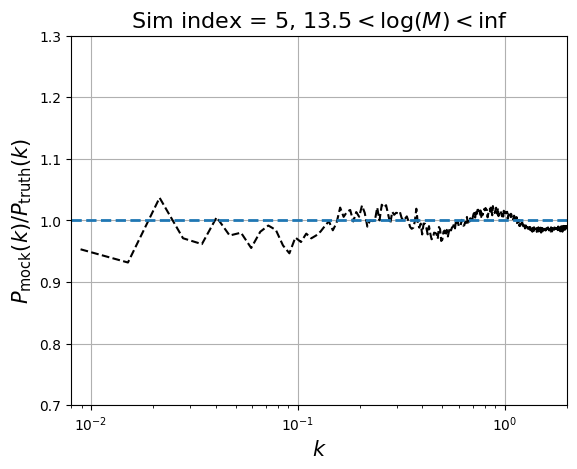

In [107]:
pl.figure()
# pl.plot(Pk_truth_full.k3D, Pk_mock_full.Pk[:,0]/Pk_truth_full.Pk[:,0], color='k', ls='-', alpha=1.0)
pl.plot(Pk_truth_full_orig.k3D, Pk_mock_full.Pk[:,0]/Pk_truth_full_orig.Pk[:,0], color='k', ls='--', alpha=1.0)
# pl.plot(Pk_truth_full_orig.k3D, Pk_truth_full.Pk[:,0]/Pk_truth_full_orig.Pk[:,0], color='k', ls=':', alpha=1.0)
# pl.plot(Pk_truth_full.k3D, Pk_mock_full.Pk[:,0]/Pk_truth_full_orig.Pk[:,0], color='k', ls='-', alpha=1.0)
# pl.plot(Pk_truth_full.k3D, Pk_truth_full.Pk[:,0]/Pk_truth_full_orig.Pk[:,0], color='k', ls='-', alpha=1.0)
# pl.plot(Pk_mock.k3D, Pk_mock.Pk[:,0], color='r', ls='--', alpha=1.0)

# resid_all = np.vstack(resid_all)
# pl.plot(Pk_truth.k3D, np.mean(resid_all, axis=0), color='k', ls='-', alpha=1.0, lw=2.0)
pl.axhline(1.0, ls='--', lw=2.0)
pl.xscale('log')
# pl.yscale('log')
pl.ylim(0.7, 1.3)
pl.xlim(0.008, 2)
# pl.scale('log')
pl.xlabel(r'$k$', size=15)
pl.grid()
# pl.ylabel(r'$\Delta P(k)/P(k)$', size=15)
pl.ylabel(r'$P_{\rm mock}(k)/P_{\rm truth}(k)$', size=15)
pl.title(f'Sim index = {isim_fid}, ' + str(Mmin_Pk) + r'$ < \log({M}) <$' + str(Mmax_Pk), size=16)




In [169]:
Pk_truth_mock_full = PKL.XPk([mesh_mock, mesh_truth], 1000., axis=0, MAS=[MAS, MAS], threads=threads)



Computing power spectra of the fields...
Time FFTS = 1.05
Time loop = 2.86
Time taken = 3.92 seconds


Text(0, 0.5, '$r(k) = P_{\\rm truth \\times mock}/\\sqrt{P_{\\rm truth} \\times P_{\\rm mock}}$')

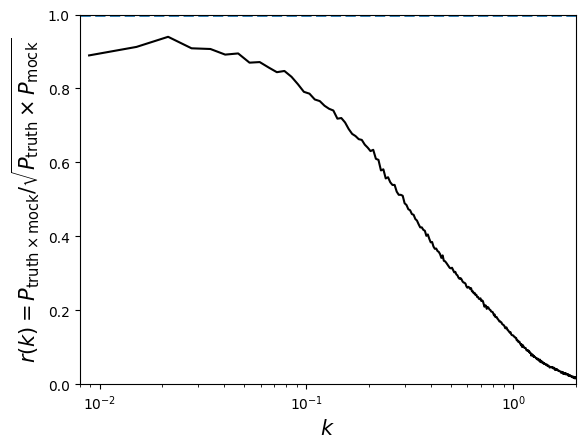

In [121]:
pl.figure()
pl.plot(Pk_truth_full.k3D, Pk_truth_mock_full.XPk[:,0,0]/np.sqrt(Pk_truth_full.Pk[:,0] * Pk_mock_full.Pk[:,0]), color='k', ls='-', alpha=1.0)
# pl.plot(Pk_mock.k3D, Pk_mock.Pk[:,0], color='r', ls='--', alpha=1.0)

# resid_all = np.vstack(resid_all)
# pl.plot(Pk_truth.k3D, np.mean(resid_all, axis=0), color='k', ls='-', alpha=1.0, lw=2.0)
pl.axhline(1.0, ls='--', lw=2.0)
pl.xscale('log')
# pl.yscale('log')
pl.ylim(0.0, 1.0)
pl.xlim(0.008, 2)
# pl.scale('log')
pl.xlabel(r'$k$', size=15)
pl.ylabel(r'$r(k) = P_{\rm truth \times mock}/\sqrt{P_{\rm truth} \times P_{\rm mock}}$', size=15)




Text(0.5, 1.0, '13.5$ < \\log({M}) <$14.0')

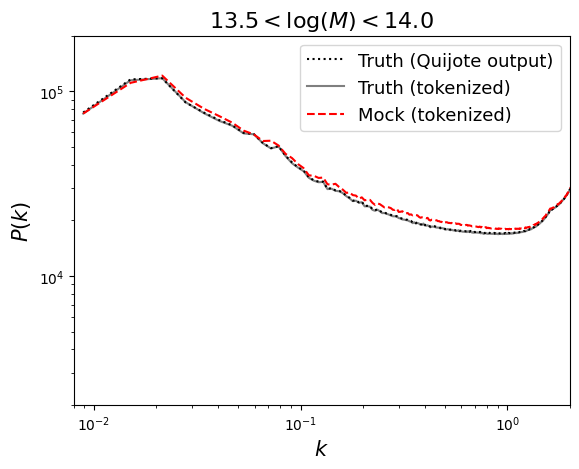

In [65]:
pl.figure()
pl.plot(Pk_truth_full.k3D, Pk_truth_full_orig.Pk[:,0], color='k', ls=':', alpha=1.0, label='Truth (Quijote output)')
pl.plot(Pk_truth_full.k3D, Pk_truth_full.Pk[:,0], color='k', ls='-', alpha=0.5, label='Truth (tokenized)')
pl.plot(Pk_mock_full.k3D, Pk_mock_full.Pk[:,0], color='r', ls='--', alpha=1.0, label='Mock (tokenized)')

# resid_all = np.vstack(resid_all)
# pl.plot(Pk_truth.k3D, np.mean(resid_all, axis=0), color='k', ls='-', alpha=1.0, lw=2.0)
# pl.axhline(0.0, ls='--', lw=2.0)
pl.xscale('log')
pl.yscale('log')
pl.legend(fontsize=13)
pl.ylim(2e3, 2e5)
pl.xlim(0.008, 2)

# pl.scale('log')
pl.xlabel(r'$k$', size=15)
pl.ylabel(r'$P(k)$', size=15)
pl.title(str(Mmin_Pk) + r'$ < \log({M}) <$' + str(Mmax_Pk), size=16)




Text(0.5, 1.0, '13.0$ < \\log({M}) <$13.5')

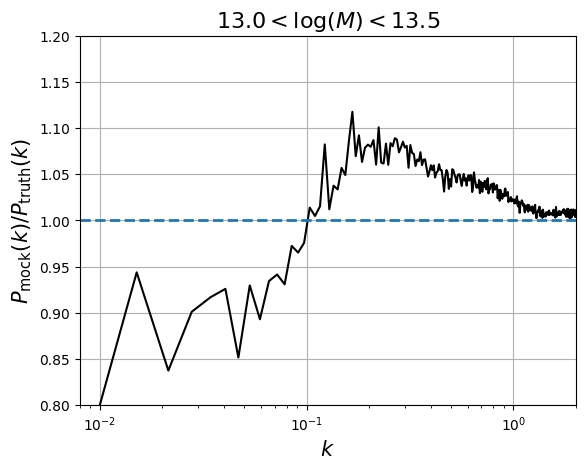

In [123]:
pl.figure()
pl.plot(Pk_truth_full.k3D, Pk_mock_full.Pk[:,0]/Pk_truth_full.Pk[:,0], color='k', ls='-', alpha=1.0)
# pl.plot(Pk_truth_full.k3D, Pk_mock_full.Pk[:,0]/Pk_truth_full_orig.Pk[:,0], color='k', ls='-', alpha=1.0)
# pl.plot(Pk_truth_full.k3D, Pk_truth_full.Pk[:,0]/Pk_truth_full_orig.Pk[:,0], color='k', ls='-', alpha=1.0)
# pl.plot(Pk_mock.k3D, Pk_mock.Pk[:,0], color='r', ls='--', alpha=1.0)

# resid_all = np.vstack(resid_all)
# pl.plot(Pk_truth.k3D, np.mean(resid_all, axis=0), color='k', ls='-', alpha=1.0, lw=2.0)
pl.axhline(1.0, ls='--', lw=2.0)
pl.xscale('log')
# pl.yscale('log')
pl.ylim(0.8, 1.2)
pl.xlim(0.008, 2)
# pl.scale('log')
pl.xlabel(r'$k$', size=15)
pl.grid()
# pl.ylabel(r'$\Delta P(k)/P(k)$', size=15)
pl.ylabel(r'$P_{\rm mock}(k)/P_{\rm truth}(k)$', size=15)
pl.title(str(Mmin_Pk) + r'$ < \log({M}) <$' + str(Mmax_Pk), size=16)



In [95]:
Nhalo_all_truth_concat = []
for jv in range(len(Nhalo_all_truth)):
    if type(Nhalo_all_truth[jv]) == int:
        Nhalo_all_truth_concat.append(Nhalo_all_truth[jv])

Nhalo_all_concat = []
for jv in range(len(Nhalo_all)):
    if type(Nhalo_all[jv]) == int:
        Nhalo_all_concat.append(Nhalo_all[jv])  

    

In [96]:
# 2+2
len(Nhalo_all_concat), len(Nhalo_all_truth_concat)
# Nhalo_all_concat[0:100]
# Nhalo_all[0]


(32682, 32043)

In [97]:
# Nhalo_all_hist
# Nhalo_all_concat[0:100]
# bins_all

In [98]:
bins_all = np.linspace(0,40, 40)
bins_cents = (bins_all[:-1] + bins_all[1:])/2
Nhalo_all_hist, _ = np.histogram(np.array(Nhalo_all_concat), bins= bins_all)
Nhalo_all_truth_hist, _ = np.histogram(np.array(Nhalo_all_truth_concat), bins= bins_all)


(0.0, 32.0)

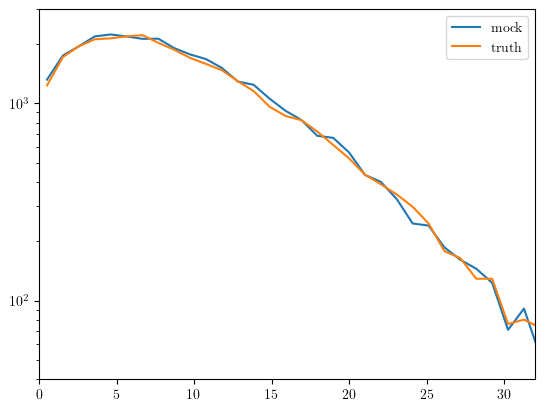

In [99]:
pl.figure()
pl.plot(bins_cents, Nhalo_all_hist, label='mock')
pl.plot(bins_cents, Nhalo_all_truth_hist, label='truth')
# _ = pl.hist(Nhalo_all_concat)
# _ = pl.hist(Nhalo_all_truth_concat)
pl.legend()
pl.yscale('log')
pl.ylim(40, 3000)
pl.xlim(0,32)




In [ ]:
pos_all_truth = []
Mhalo_all_truth = []
Nhalo_all_truth = []
# Pk_all_truth = []

BoxSize = 1000.
grid = 32
xmin = BoxSize/grid/2

MAS     = 'NGP'  #mass-assigment scheme
grid_Pk = 32
threads = 10

for jv in range(nvox_samp):
# for jv in indhigh[:nvox_samp]:    
    idx = X_val[jv]
    idx = idx.cpu().numpy().flatten()
    # idx = idx[1:]
    # idx = idx[:np.where(idx == end_token)[0][0]]
    # idx = idx.reshape(-1, 5)
    idxe = np.where(idx == space_token)[0] + 1
    idx0 = np.where(idx == start_token)[0] + 1
    # check with idx0 is a scalar or an array:
    # try:
        # temp = len(idx0)
        # print(temp)
    # except:
    if len(idx0) == 1:
        Nhalo = len(idxe) + len(idx0)
        Nhalo_all_truth.append(Nhalo)
    
        if Nhalo > 0:
            try:
                Mhalo = np.zeros(Nhalo)
                pos_halo = np.zeros((Nhalo, 3))
                for jh in range(Nhalo):
                    if jh == 0:
                        Mhalo[jh] = bins_digitize[idx[idx0]] * (lgMax - lgMin) + lgMin
                        for jx in range(3):
                            pos_halo[jh, jx] = bins_digitize[idx[idx0 + jx + 1]] * 2 * xmin            
                    else:
                        if Nhalo > 2:
                            Mhalo[jh] = bins_digitize[idx[idxe[jh-1]]] * (lgMax - lgMin) + lgMin
                            for jx in range(3):
                                pos_halo[jh, jx] = bins_digitize[idx[idxe[jh-1] + jx + 1]] * 2 * xmin            
                        else:
                            Mhalo[jh] = bins_digitize[idx[idxe]] * (lgMax - lgMin) + lgMin
                            for jx in range(3):
                                pos_halo[jh, jx] = bins_digitize[idx[idxe + jx + 1]] * 2 * xmin            

                Mhalo_all_truth.append(Mhalo)
                pos_all_truth.append(pos_halo)

                if Nhalo > 5:
                    mesh_truth = np.zeros((grid_Pk, grid_Pk, grid_Pk), dtype=np.float32)
                    MASL.MA(pos_halo.astype(np.float32), mesh_truth, 2*xmin, MAS)
                    mesh_truth /= np.mean(mesh_truth, dtype=np.float64);  mesh_truth -= 1.0
                    Pk_truth = PKL.Pk(mesh_truth, 2*xmin, axis=0, MAS=None, threads=threads, verbose=False)
                    Pk_all_truth.append(Pk_truth.Pk[:,0])
                else:
                    Pk_all_truth.append([])

            except:
                Mhalo_all_truth.append(np.array([]))
                pos_all_truth.append(np.array([]))
                Pk_all_truth.append([])                
                pass
        else:
            Mhalo_all_truth.append(np.array([]))
            pos_all_truth.append(np.array([]))
            Pk_all_truth.append([])                
    else:
        Nhalo_all_truth.append(np.array([]))
        Mhalo_all_truth.append(np.array([]))
        pos_all_truth.append(np.array([]))
        Pk_all_truth.append([])                


In [24]:
pos_all_truth = []
Mhalo_all_truth = []
Nhalo_all_truth = []
Pk_all_truth = []

BoxSize = 1000.
grid = 32
xmin = BoxSize/grid/2

MAS     = 'NGP'  #mass-assigment scheme
grid_Pk = 32
threads = 10

# for jv in range(nvox_samp):
for jv in indhigh[:nvox_samp]:    
    idx = X_val[jv]
    idx = idx.cpu().numpy().flatten()
    # idx = idx[1:]
    # idx = idx[:np.where(idx == end_token)[0][0]]
    # idx = idx.reshape(-1, 5)
    idxe = np.where(idx == space_token)[0] + 1
    idx0 = np.where(idx == start_token)[0] + 1
    # check with idx0 is a scalar or an array:
    # try:
        # temp = len(idx0)
        # print(temp)
    # except:
    if len(idx0) == 1:
        Nhalo = len(idxe) + len(idx0)
        Nhalo_all_truth.append(Nhalo)
    
        if Nhalo > 0:
            try:
                Mhalo = np.zeros(Nhalo)
                pos_halo = np.zeros((Nhalo, 3))
                for jh in range(Nhalo):
                    if jh == 0:
                        Mhalo[jh] = bins_digitize[idx[idx0]] * (lgMax - lgMin) + lgMin
                        for jx in range(3):
                            pos_halo[jh, jx] = bins_digitize[idx[idx0 + jx + 1]] * 2 * xmin            
                    else:
                        if Nhalo > 2:
                            Mhalo[jh] = bins_digitize[idx[idxe[jh-1]]] * (lgMax - lgMin) + lgMin
                            for jx in range(3):
                                pos_halo[jh, jx] = bins_digitize[idx[idxe[jh-1] + jx + 1]] * 2 * xmin            
                        else:
                            Mhalo[jh] = bins_digitize[idx[idxe]] * (lgMax - lgMin) + lgMin
                            for jx in range(3):
                                pos_halo[jh, jx] = bins_digitize[idx[idxe + jx + 1]] * 2 * xmin            

                Mhalo_all_truth.append(Mhalo)
                pos_all_truth.append(pos_halo)

                if Nhalo > 5:
                    mesh_truth = np.zeros((grid_Pk, grid_Pk, grid_Pk), dtype=np.float32)
                    MASL.MA(pos_halo.astype(np.float32), mesh_truth, 2*xmin, MAS)
                    mesh_truth /= np.mean(mesh_truth, dtype=np.float64);  mesh_truth -= 1.0
                    Pk_truth = PKL.Pk(mesh_truth, 2*xmin, axis=0, MAS=None, threads=threads, verbose=False)
                    Pk_all_truth.append(Pk_truth.Pk[:,0])
                else:
                    Pk_all_truth.append([])

            except:
                Mhalo_all_truth.append(np.array([]))
                pos_all_truth.append(np.array([]))
                Pk_all_truth.append([])                
                pass
        else:
            Mhalo_all_truth.append(np.array([]))
            pos_all_truth.append(np.array([]))
            Pk_all_truth.append([])                
    else:
        Nhalo_all_truth.append(np.array([]))
        Mhalo_all_truth.append(np.array([]))
        pos_all_truth.append(np.array([]))
        Pk_all_truth.append([])                


/tmp/ipykernel_2188932/359875854.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Mhalo[jh] = bins_digitize[idx[idx0]] * (lgMax - lgMin) + lgMin
/tmp/ipykernel_2188932/359875854.py:40: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pos_halo[jh, jx] = bins_digitize[idx[idx0 + jx + 1]] * 2 * xmin


In [25]:
# len(Pk_all_truth)
# Pk_truth.Pk.shape, Pk_truth.k3D.shape



In [26]:
# idx_all
Nhalo_all = []
Mhalo_all = []
Pk_all = []

for jv in range(nvox_samp):
    idx = idx_all[jv]
    idx = idx.cpu().numpy().flatten()
    # idx = idx[1:]
    # idx = idx[:np.where(idx == end_token)[0][0]]
    # idx = idx.reshape(-1, 5)
    idxe = np.where(idx == space_token)[0] + 1
    idx0 = np.where(idx == start_token)[0] + 1
    # check with idx0 is a scalar or an array:
    # try:
        # temp = len(idx0)
        # print(temp)
    # except:
    if len(idx0) == 1:
        Nhalo = len(idxe) + len(idx0)
        Nhalo_all.append(Nhalo)
    
        if Nhalo > 0:
            try:
                Mhalo = np.zeros(Nhalo)
                pos_halo = np.zeros((Nhalo, 3))                
                for jh in range(Nhalo):
                    if jh == 0:
                        Mhalo[jh] = bins_digitize[idx[idx0]] * (lgMax - lgMin) + lgMin
                        for jx in range(3):
                            pos_halo[jh, jx] = bins_digitize[idx[idx0 + jx + 1]] * 2 * xmin            

                    else:
                        if Nhalo > 2:
                            Mhalo[jh] = bins_digitize[idx[idxe[jh-1]]] * (lgMax - lgMin) + lgMin
                            for jx in range(3):
                                pos_halo[jh, jx] = bins_digitize[idx[idxe[jh-1] + jx + 1]] * 2 * xmin            

                        else:
                            Mhalo[jh] = bins_digitize[idx[idxe]] * (lgMax - lgMin) + lgMin
                            for jx in range(3):
                                pos_halo[jh, jx] = bins_digitize[idx[idxe + jx + 1]] * 2 * xmin            

                Mhalo_all.append(Mhalo)

                if Nhalo > 5:
                    mesh_truth = np.zeros((grid_Pk, grid_Pk, grid_Pk), dtype=np.float32)
                    MASL.MA(pos_halo.astype(np.float32), mesh_truth, 2*xmin, MAS)
                    mesh_truth /= np.mean(mesh_truth, dtype=np.float64);  mesh_truth -= 1.0
                    Pk_truth = PKL.Pk(mesh_truth, 2*xmin, axis=0, MAS=None, threads=threads, verbose=False)
                    Pk_all.append(Pk_truth.Pk[:,0])
                else:
                    Pk_all.append([])


            except:
                Mhalo_all.append(np.array([]))
                Pk_all.append([])
                pass
        else:
            Mhalo_all.append(np.array([]))
            Pk_all.append([])

    else:
        Nhalo_all.append(np.array([]))
        Mhalo_all.append(np.array([]))
        Pk_all.append([])



/tmp/ipykernel_2188932/260296683.py:29: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Mhalo[jh] = bins_digitize[idx[idx0]] * (lgMax - lgMin) + lgMin
/tmp/ipykernel_2188932/260296683.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pos_halo[jh, jx] = bins_digitize[idx[idx0 + jx + 1]] * 2 * xmin


Text(0, 0.5, '$\\Delta P(k)/P(k)$')

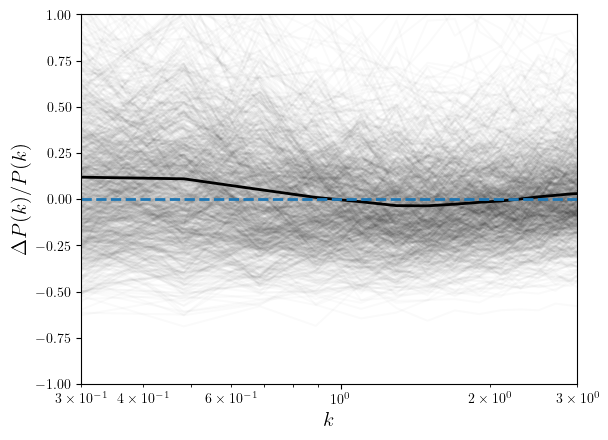

In [27]:
pl.figure()
resid_all = []
for jp in range(len(Pk_all)):
    if (len(Pk_all[jp]) > 0) and (len(Pk_all_truth[jp]) > 0):
        pl.plot(Pk_truth.k3D, (Pk_all[jp] - Pk_all_truth[jp])/Pk_all_truth[jp], color='k', ls='-', alpha=0.02)
        resid_all.append((Pk_all[jp] - Pk_all_truth[jp])/Pk_all_truth[jp])

resid_all = np.vstack(resid_all)
pl.plot(Pk_truth.k3D, np.mean(resid_all, axis=0), color='k', ls='-', alpha=1.0, lw=2.0)
pl.axhline(0.0, ls='--', lw=2.0)
pl.xscale('log')
pl.ylim(-1.0, 1.0)
pl.xlim(0.3, 3)
# pl.scale('log')
pl.xlabel(r'$k$', size=15)
pl.ylabel(r'$\Delta P(k)/P(k)$', size=15)




Text(0, 0.5, '$P(k)$')

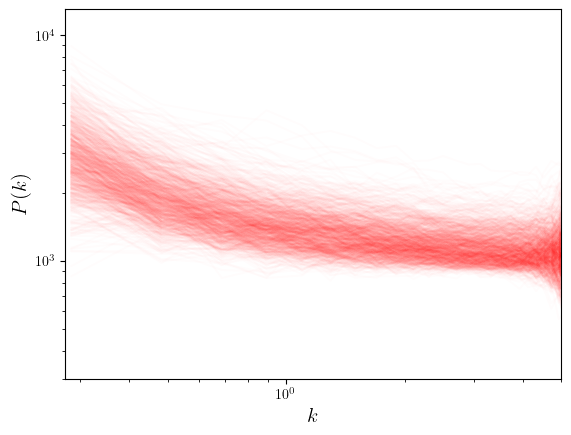

In [28]:
pl.figure()
Pktruth_mean_all = []
for jp in range(len(Pk_all)):
    if (len(Pk_all[jp]) > 0) and (len(Pk_all_truth[jp]) > 0):
        pl.plot(Pk_truth.k3D, Pk_all_truth[jp], color='r', ls='-', alpha=0.01)
        Pktruth_mean_all.append(Pk_all_truth[jp])
        # pl.plot(Pk_truth.k3D, Pk_all_truth[jp], color='b', ls='--', alpha=0.01)
        # resid_all.append((Pk_all[jp] - Pk_all_truth[jp])/Pk_all_truth[jp])
Pktruth_mean_all = np.vstack(Pktruth_mean_all)
# resid_all = np.vstack(resid_all)
# pl.plot(Pk_truth.k3D, np.mean(resid_all, axis=0), color='k', ls='-', alpha=1.0, lw=2.0)
pl.xscale('log')
pl.yscale('log')
# pl.ylim(-0.5, 0.5)
pl.xlim(0.275, 5)
pl.ylim(3e2, 1.3e4)
# pl.scale('log')
pl.xlabel(r'$k$', size=15)
pl.ylabel(r'$P(k)$', size=15)
# pl.title(r'Truth', size)



Text(0, 0.5, '$P(k)$')

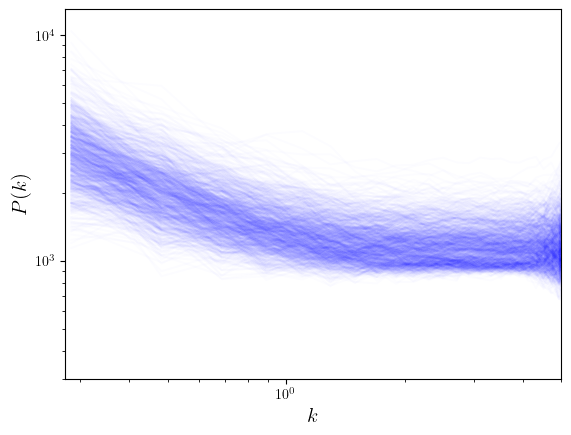

In [29]:
pl.figure()
Pk_mean_all = []
for jp in range(len(Pk_all)):
    if (len(Pk_all[jp]) > 0) and (len(Pk_all_truth[jp]) > 0):
        pl.plot(Pk_truth.k3D, Pk_all[jp], color='b', ls='-', alpha=0.01)
        Pk_mean_all.append(Pk_all[jp])
        # pl.plot(Pk_truth.k3D, Pk_all_truth[jp], color='b', ls='--', alpha=0.01)
        # resid_all.append((Pk_all[jp] - Pk_all_truth[jp])/Pk_all_truth[jp])
Pk_mean_all = np.vstack(Pk_mean_all)
# resid_all = np.vstack(resid_all)
# pl.plot(Pk_truth.k3D, np.mean(resid_all, axis=0), color='k', ls='-', alpha=1.0, lw=2.0)
pl.xscale('log')
pl.yscale('log')
# pl.ylim(-0.5, 0.5)
pl.xlim(0.275, 5)
pl.ylim(3e2, 1.3e4)
# pl.scale('log')
pl.xlabel(r'$k$', size=15)
pl.ylabel(r'$P(k)$', size=15)
# pl.title(r'Truth', size)



Text(0, 0.5, '$P(k)$')

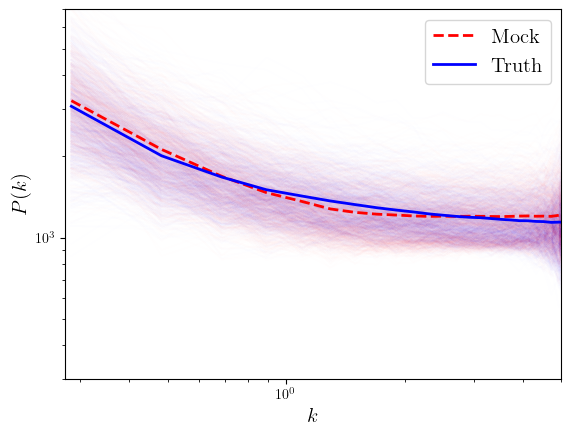

In [32]:
pl.figure()
for jp in range(len(Pk_all)):
    if (len(Pk_all[jp]) > 0) and (len(Pk_all_truth[jp]) > 0):
        pl.plot(Pk_truth.k3D, Pk_all[jp], color='r', ls='-', alpha=0.004)
        # Pk_mean_all.append(Pk_all[jp])

Pktruth_mean_all = []
for jp in range(len(Pk_all)):
    if (len(Pk_all[jp]) > 0) and (len(Pk_all_truth[jp]) > 0):
        pl.plot(Pk_truth.k3D, Pk_all_truth[jp], color='b', ls='-', alpha=0.004)
        Pktruth_mean_all.append(Pk_all_truth[jp])

# Pk_mean_all = []
# for jp in range(len(Pk_all)):
    # if (len(Pk_all[jp]) > 0) and (len(Pk_all_truth[jp]) > 0):
        # pl.plot(Pk_truth.k3D, Pk_all[jp], color='b', ls='-', alpha=0.01)
        # Pk_mean_all.append(Pk_all[jp])
        # pl.plot(Pk_truth.k3D, Pk_all_truth[jp], color='b', ls='--', alpha=0.01)
        # resid_all.append((Pk_all[jp] - Pk_all_truth[jp])/Pk_all_truth[jp])
# Pk_mean_all = np.vstack(Pk_mean_all)
# resid_all = np.vstack(resid_all)
pl.plot(Pk_truth.k3D, np.mean(Pk_mean_all, axis=0), color='r', ls='--', alpha=1.0, lw=2.0, label=r'Mock')
pl.plot(Pk_truth.k3D, np.mean(Pktruth_mean_all, axis=0), color='b', ls='-', alpha=1.0, lw=2.0, label=r'Truth')
pl.xscale('log')
pl.yscale('log')
# pl.ylim(-0.5, 0.5)
pl.xlim(0.275, 5)
pl.ylim(3e2, 7e3)
pl.legend(fontsize=15)
# pl.scale('log')
pl.xlabel(r'$k$', size=15)
pl.ylabel(r'$P(k)$', size=15)
# pl.title(r'Truth', size)



In [33]:
np.mean(Pk_mean_all, axis=0)/np.mean(Pktruth_mean_all, axis=0)


array([1.0486252 , 1.05577959, 1.00665098, 0.97575422, 0.9546787 ,
       0.93452781, 0.93591016, 0.94635405, 0.95848757, 0.96656779,
       0.97886587, 0.99196451, 1.00044523, 1.00899766, 1.0120348 ,
       1.01731845, 1.02384885, 1.03089531, 1.03986128, 1.04235678,
       1.04500534, 1.04772846, 1.05269957, 1.06006241, 1.05776604,
       1.04989725, 1.0576422 ])

In [39]:
Mhalo_all_truth_concat = []
for jv in range(len(Mhalo_all_truth)):
    Mhalo_all_truth_concat.extend(Mhalo_all_truth[jv])

Mhalo_all_concat = []
for jv in range(len(Mhalo_all)):
    Mhalo_all_concat.extend(Mhalo_all[jv])    


Text(0.5, 1.0, 'High density voxels, $\\bar{\\delta}_{{\\rm 32Mpc}/h} > 1.3$')

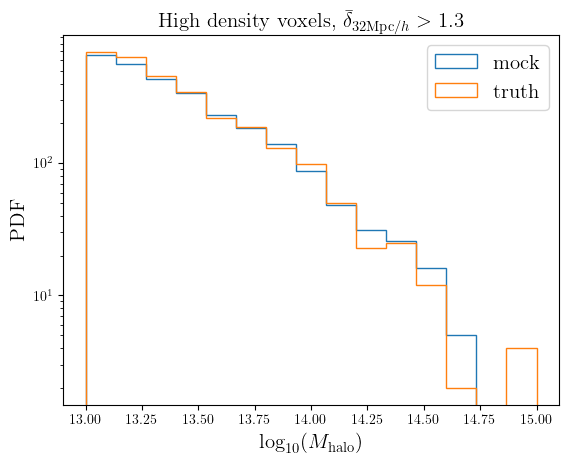

In [40]:
pl.figure()
_ = pl.hist(Mhalo_all_concat, bins=15, range=(lgMin, 15),  histtype='step', label='mock')
# _ = pl.hist(lgMsim_truth, bins=15, range=(lgMin, 15), density=True, histtype='step', label='truth')
_ = pl.hist(Mhalo_all_truth_concat, bins=15, range=(lgMin, 15), histtype='step', label='truth')
pl.yscale('log')
pl.legend(fontsize=15)
pl.xlabel(r'$\log_{10}(M_{\rm halo})$', size=15)
pl.ylabel(r'PDF', size=15)
pl.title(r'High density voxels, $\bar{\delta}_{{\rm 32Mpc}/h} > 1.3$', size=15)






In [57]:
Mhalo_all_concat_low = []
Mhalo_all_concat_mid = []
Mhalo_all_concat_high = []
for jv in indlow:
    Mhalo_all_concat_low.extend(Mhalo_all[jv])

for jv in indmid:
    Mhalo_all_concat_mid.extend(Mhalo_all[jv])

for jv in indhigh:
    Mhalo_all_concat_high.extend(Mhalo_all[jv])
    

In [58]:
# Mhalo_all_truth_concat = []
# for jv in range(len(Mhalo_all_truth)):
    # Mhalo_all_truth_concat.extend(Mhalo_all_truth[jv])

Mhalo_all_truth_concat_low = []
Mhalo_all_truth_concat_mid = []
Mhalo_all_truth_concat_high = []

for jv in indlow:
    Mhalo_all_truth_concat_low.extend(Mhalo_all_truth[jv])

for jv in indmid:
    Mhalo_all_truth_concat_mid.extend(Mhalo_all_truth[jv])

for jv in indhigh:
    Mhalo_all_truth_concat_high.extend(Mhalo_all_truth[jv])

    



Text(0.5, 1.0, 'High density voxels, $\\bar{\\delta}_{{\\rm 32Mpc}/h} > 1.3$')

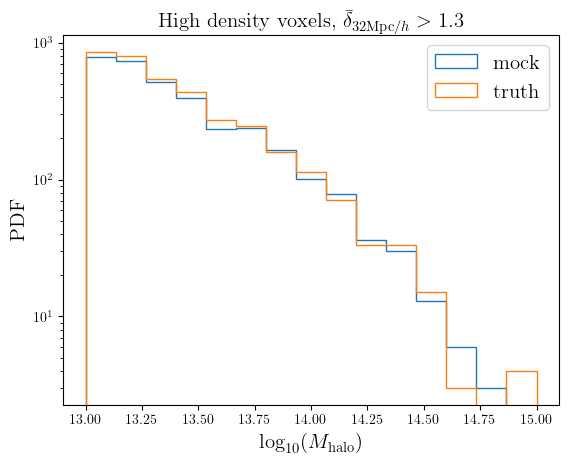

In [59]:
pl.figure()
_ = pl.hist(Mhalo_all_concat_high, bins=15, range=(lgMin, 15),  histtype='step', label='mock')
# _ = pl.hist(lgMsim_truth, bins=15, range=(lgMin, 15), density=True, histtype='step', label='truth')
_ = pl.hist(Mhalo_all_truth_concat_high, bins=15, range=(lgMin, 15), histtype='step', label='truth')
pl.yscale('log')
pl.legend(fontsize=15)
pl.xlabel(r'$\log_{10}(M_{\rm halo})$', size=15)
pl.ylabel(r'PDF', size=15)
pl.title(r'High density voxels, $\bar{\delta}_{{\rm 32Mpc}/h} > 1.3$', size=15)



Text(0.5, 1.0, 'Mid density voxels, $0.75 < \\bar{\\delta}_{{\\rm 32Mpc}/h} < 1.3$')

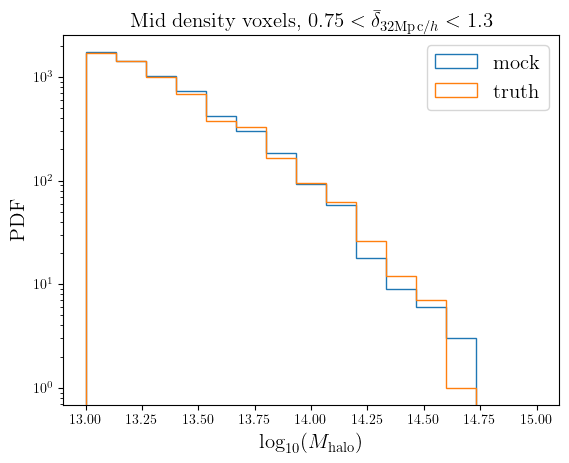

In [60]:
pl.figure()
_ = pl.hist(Mhalo_all_concat_mid, bins=15, range=(lgMin, 15), histtype='step', label='mock')
# _ = pl.hist(lgMsim_truth, bins=15, range=(lgMin, 15), density=True, histtype='step', label='truth')
_ = pl.hist(Mhalo_all_truth_concat_mid, bins=15, range=(lgMin, 15), histtype='step', label='truth')
pl.yscale('log')
pl.legend(fontsize=15)
pl.xlabel(r'$\log_{10}(M_{\rm halo})$', size=15)
pl.ylabel(r'PDF', size=15)
pl.title(r'Mid density voxels, $0.75 < \bar{\delta}_{{\rm 32Mpc}/h} < 1.3$', size=15)



Text(0.5, 1.0, 'Low density voxels, $\\bar{\\delta}_{{\\rm 32Mpc}/h} < 0.75$')

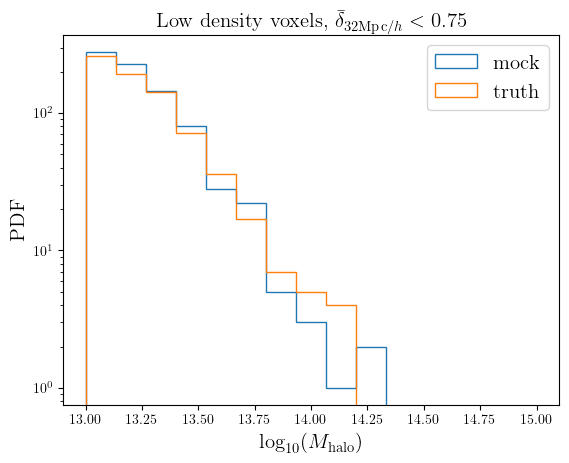

In [61]:
pl.figure()
_ = pl.hist(Mhalo_all_concat_low, bins=15, range=(lgMin, 15), histtype='step', label='mock')
# _ = pl.hist(lgMsim_truth, bins=15, range=(lgMin, 15), density=True, histtype='step', label='truth')
_ = pl.hist(Mhalo_all_truth_concat_low, bins=15, range=(lgMin, 15), histtype='step', label='truth')
pl.yscale('log')
pl.legend(fontsize=15)
pl.xlabel(r'$\log_{10}(M_{\rm halo})$', size=15)
pl.ylabel(r'PDF', size=15)
pl.title(r'Low density voxels, $\bar{\delta}_{{\rm 32Mpc}/h} < 0.75$', size=15)



In [64]:
from tqdm import tqdm
indhigh_to_plot = indhigh[::4]
idx_inp = torch.zeros((1, 1), dtype=torch.long, device=dev)
nvox_samp = len(indhigh_to_plot)
max_new_tokens = 160
end_token = 129
idx_all = []
for jv in tqdm(range(nvox_samp)):
    ind_jv = indhigh_to_plot[jv]
    DM_val_jv = DM_val[ind_jv,...]
    idx = idx_inp
    for _ in range(max_new_tokens):
        # crop idx to the last block_size tokens
        idx_cond = idx[:, -block_size:]
        # get the predictions
        logits, loss = model(idx_cond, DM_val_jv.unsqueeze(0))
        # focus only on the last time step
        logits = logits[:, -1, :] # becomes (B, C)
        # apply softmax to get probabilities
        probs = F.softmax(logits, dim=-1) # (B, C)
        # sample from the distribution
        idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
        # append sampled index to the running sequence
        if idx_next == end_token:
            break
        idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
    idx_all.append(idx)
    



(tensor([  0,  54,  53, 121, 106, 130,  41,  11,  99,  19, 130,  20,  68, 123,
         122, 130,  19,  69, 104, 119, 130,  17, 119, 121, 117, 130,   8,  77,
         100, 110, 130,   7,  70, 125,  37, 130,   6,  54, 113,  95, 130,   5,
          83, 126,   4, 130,   2,  71, 102, 119, 129,   1,   1,   1,   1,   1,
           1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
           1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
           1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
           1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
           1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
           1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
           1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
           1,   1,   1,   1,   1,   1], device='cuda:0'),
 tensor([[  0,  60,  59, 119, 104, 130,  44,  59, 118, 109, 130,  35,  35

In [84]:
indhigh


array([   14,    18,    20, ..., 16353, 16374, 16382])